In [4]:
import json
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
 
from qiskit import transpile, QuantumCircuit
from qiskit.visualization import timeline_drawer
from qiskit_ibm_provider import IBMProvider

from BaconShor3CXheavyhex import BS3CXheavyhex
from utils import transDD, build_stim_circuit, string2detections,Fidelity_yield_from_detector_samples
import surface_code_decoder_v2

home = os.getcwd()

In [5]:
provider = IBMProvider()
backend = provider.get_backend('ibm_torino')

# Device benchmark data

In [36]:
t = datetime(day=11, month=2, year=2024, hour=20)
calib_props = backend.properties(datetime=t)

In [37]:
code = BS3CXheavyhex(d=4,T=1,logical_prep = ['Z','Z'],logical_meas = ['Z','Z'], offset = -2+6j, num_qubits=133)

In [38]:
cz_errors = {}
for inst in code.circuit:
    if inst.operation.name == 'cx':
        index_pair = tuple(np.sort([q._index for q in inst.qubits]))
        cz_errors[index_pair] = calib_props.gate_error("cz",[q._index for q in inst.qubits])
print('avg cz error:', [np.average(list(cz_errors.values())),np.median(list(cz_errors.values()))])

vertex_qubits = [code.heavyHEX_dict[pos] for pos in list(code.q2i3CX.keys())+list(code.a2i3CX.keys())]
link_qubits = [code.heavyHEX_dict[pos] for pos in list(code.q2iBS.keys())+list(code.q2iBS.keys())]
for label,qubits in zip(['vertex qubits','link qubits'],[vertex_qubits,link_qubits]):
    print(label)
    T1_list = []
    T2_list = []
    R_error_list = []
    singleQ_error_list = []
    for q in qubits:
        prop = calib_props.qubit_property(q)
        T1_list.append(prop['readout_length'][0]/prop['T1'][0])
        T2_list.append(prop['readout_length'][0]/prop['T2'][0])
        R_error_list.append(prop['readout_error'][0])
        singleQ_error_list.append(calib_props.gate_error('sx',q))
    print("avg. TRO/T1, TRO/T2, RO error, 1Q error: ", [np.average(T1_list),np.median(T1_list)], [np.average(T2_list),np.median(T2_list)],[np.average(R_error_list),np.median(R_error_list)], [np.average(singleQ_error_list),np.median(singleQ_error_list)])

avg cz error: [0.005463007940202015, 0.003785925198922596]
vertex qubits
avg. TRO/T1, TRO/T2, RO error, 1Q error:  [0.012839394657999896, 0.00873120767906749] [0.01688389900813041, 0.011650979063291532] [0.034390322580645165, 0.031299999999999994] [0.00032537453112003144, 0.0002571977644509059]
link qubits
avg. TRO/T1, TRO/T2, RO error, 1Q error:  [0.009273150596447203, 0.007416431923334233] [0.01308485778847538, 0.012488079197115767] [0.010593749999999992, 0.010299999999999976] [0.00047475796653675235, 0.0003686764494010132]


# Bacon-Shor code only

In [98]:
def onlyBS(d, T,logical_prep, offset = -2+6j,
            num_qubits = -1, 
            virt_link = False,
            CXerror=0, Rerror=0,singleQerror=0):
    """We still do measurements on the other sublattice, but there are no additional CX layers from the 3CX code"""
    
    code = BS3CXheavyhex(d=d, T=T, logical_prep=['Z',logical_prep], logical_meas=['Z',logical_prep], offset=offset,
                            num_qubits=num_qubits, 
                            virt_link=virt_link,
                            CX_schedule = ['BSZ0', 'BSZ1','BSX0', 'BSX1'],
                            CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror)
    return code

## Simulations

In [5]:
code = onlyBS(d=2,T=2,logical_prep = 'Z',CXerror=0.01)

stim_circuit,relevant_nodes = build_stim_circuit(code,return_relevant_nodes=True)
stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)

stim_DEM.diagram(type="match-graph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":80,"max":[49,15,16],"min":[39,15,-10],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":34,"max":[49,15,16],"min":[39,15,-10],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":960,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":2,"byteLength":408,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":960,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAAAAAAAcQgAAcEEAAEBAAAAcQgAAcEEAAAAAAAAcQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAAAcQgAAcEEAAMBAAAAcQgAAcEEAAEBAAAAcQgAAcEEAAMBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBA"},{"byteLength":408,"name":"buf_red_scattered_lines","uri":"data:application/octet-stream;base64,AAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAAAAAAAcQgAAcEEAACDBAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBAAAAcQgAAcEEAAMBAAAAcQgAAcEEAAIBBAAAcQgAAcEEAAEBAAABEQgAAcEEAAEBA"}],"materials":[{"doubleSided":true,"name":"black","pbrMetallicRoughness":{"baseColorFactor":[0,0,0,1],"metallicFactor":1,"roughnessFactor":1}},{"doubleSided":true,"name":"black","pbrMetallicRoughness":{"baseColorFactor":[0,0,0,1],"metallicFactor":1,"roughnessFactor":1}},{"doubleSided":true,"name":"red","pbrMetallicRoughness":{"baseColorFactor":[1,0,0,1],"metallicFactor":1,"roughnessFactor":1}}],"meshes":[{"primitives":[{"attributes":{"POSITION":0},"material":0,"mode":6}]},{"primitives":[{"attributes":{"POSITION":1},"material":1,"mode":1}]},{"primitives":[{"attributes":{"POSITION":2},"material":2,"mode":1}]}],"nodes":[{"mesh":0,"translation":[39,15,3]},{"mesh":0,"translation":[39,15,0]},{"mesh":0,"translation":[39,15,3]},{"mesh":0,"translation":[39,15,6]},{"mesh":1,"translation":[0,0,0]},{"mesh":2,"transl

In [38]:
dist_list = list(range(3,11,2))
error_list = 1*np.logspace(-4,-2,10)
max_shots = 1_000_000
shot_batch = 10_000
max_num_fail = 1_000
log_prep = 'Z'

PS = False

Log_fail_d_p = []
for d in dist_list:
    T=d
    Log_fail_p =[]
    for error in error_list:
        code = onlyBS(d=d, T=T, logical_prep=log_prep,
                    CXerror=error, Rerror=error,singleQerror=error)

        stim_circuit,relevant_nodes = build_stim_circuit(code, return_relevant_nodes=True)
        stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
        if PS:
            matching0 = surface_code_decoder_v2.DEM_to_postsel_matching(model=stim_DEM,relevant_nodes=relevant_nodes)
        else:
            matching0 = surface_code_decoder_v2.DEM_to_matching(model=stim_DEM,relevant_nodes=relevant_nodes)
        num_obs = 1

        num_fail = np.array([0]*num_obs)
        num_shots = 0
        num_shots2 = 0
        while num_shots<max_shots and min(num_fail)<max_num_fail:
            num_shots += shot_batch
            detector_samples = stim_circuit.compile_detector_sampler().sample(shot_batch, append_observables=True)
            correction_batch = matching0.decode_batch(detector_samples)
            num_shots2+=len(correction_batch)
            num_fail+=sum(correction_batch)

        print(d,error,min(num_fail)/num_shots2,'+/-',np.sqrt(min(num_fail))/num_shots2, num_shots2/num_shots)

        Log_fail_p.append([error,min(num_fail)/num_shots2,np.sqrt(min(num_fail))/num_shots2])

    Log_fail_d_p.append([d,Log_fail_p])

3 0.0001 2.277227722772277e-05 +/- 4.74834804288388e-06 1.0
3 0.0001668100537200059 6.237623762376238e-05 +/- 7.858667260587893e-06 1.0
3 0.0002782559402207126 0.00020792079207920792 +/- 1.4347897768504394e-05 1.0
3 0.00046415888336127773 0.0005168316831683169 +/- 2.2621108235239333e-05 1.0
3 0.000774263682681127 0.0016193548387096774 +/- 5.1106385541144706e-05 1.0
3 0.001291549665014884 0.004092 +/- 0.0001279374847337558 1.0
3 0.002154434690031882 0.01084 +/- 0.0003292415526630866 1.0
3 0.003593813663804626 0.028 +/- 0.0008366600265340755 1.0
3 0.005994842503189409 0.06845 +/- 0.00185 1.0
3 0.01 0.1462 +/- 0.003823610858861032 1.0
5 0.0001 9.900990099009902e-07 +/- 9.900990099009902e-07 1.0
5 0.0001668100537200059 8.910891089108911e-06 +/- 2.9702970297029703e-06 1.0
5 0.0002782559402207126 6.435643564356436e-05 +/- 7.98243341415698e-06 1.0
5 0.00046415888336127773 0.00025544554455445543 +/- 1.5903344954662386e-05 1.0
5 0.000774263682681127 0.0010702127659574468 +/- 3.374202452585895e-

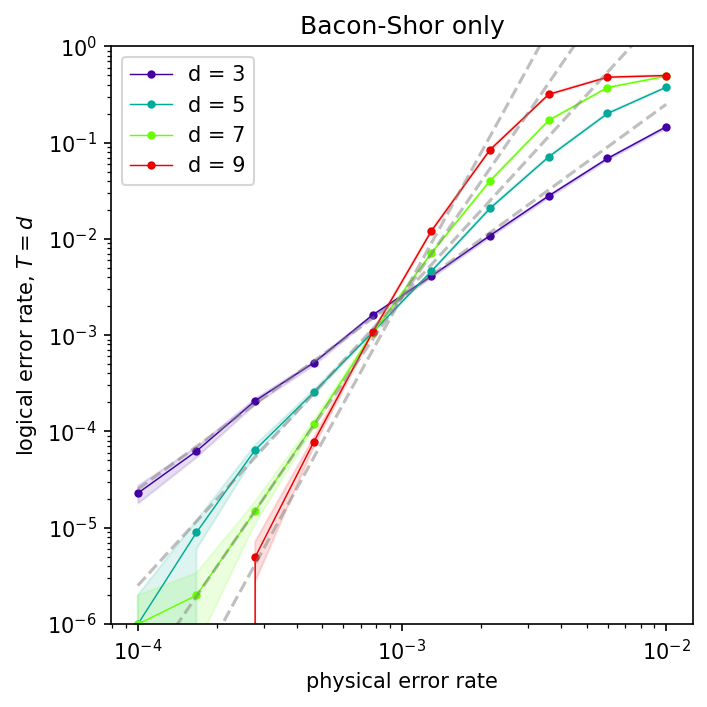

In [55]:
color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/len(dist_list)) for i in range(len(dist_list))]


fig=plt.figure(figsize=(5, 5), dpi=150)

for di,d in enumerate(dist_list):
    phys_err, log_err, _ = np.transpose(Log_fail_d_p[di][1])
    plt.plot(phys_err, log_err,'.-', c=color_list[di],linewidth = 0.7)

plt.legend(['d = '+str(d) for d in dist_list])

pth,pLatth = 1e-3,0.0025

for di,d in enumerate(dist_list):
    phys_err, log_err, log_err_err = np.transpose(Log_fail_d_p[di][1])
    log_err_err = np.array(log_err_err, dtype=float)
    log_err = np.array(log_err, dtype=float)
    phys_err = np.array(phys_err, dtype=float)
    plt.fill_between(phys_err, log_err-log_err_err, log_err+log_err_err,alpha = 0.13,color=color_list[di]) 
    plt.plot(error_list, pLatth*(error_list/pth)**np.ceil((d+1)/2),'--',c='gray', alpha=0.5)

# plt.axvline(pth,linestyle=':',c="gray", alpha=0.3)

plt.title(r'Bacon-Shor only')
plt.xlabel(r'physical error rate')
plt.ylabel(r'logical error rate, $T = d$')
plt.ylim(1e-6,1)
plt.loglog()
# plt.savefig(home+'/figures/threshold_plot_dT3to9_BSonly_nops.pdf',bbox_inches = 'tight')
plt.show()

## Device data

### collecting data

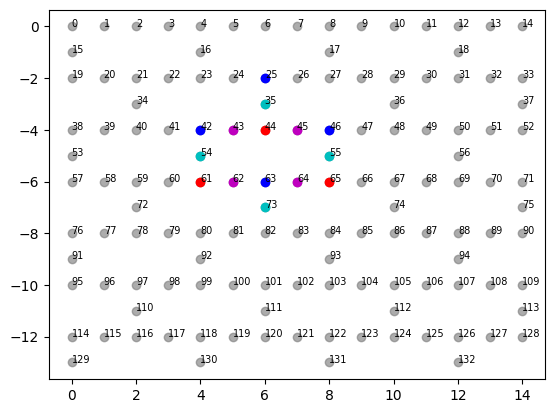

In [53]:
num_qubits = 133

d,T=2,2
code = onlyBS(d=d,T=T,logical_prep = 'Z',offset = 0+4j,num_qubits=133)
qc = code.circuit
rep_delay=backend.configuration().rep_delay_range[1]
qc.barrier()
qc.delay(0.01*rep_delay,unit='s')
qc.draw(fold=-1,idle_wires=False)
init_layout = [qc.qubits[q] for q in range(qc.num_qubits)]
qc_trans = transDD(qc,backend,echo = 'XZX', qubit_list=code.qubit_index_listBS)

code.draw_lattice()

In [55]:
# timeline_drawer(qc_trans,show_idle=False)

In [56]:
num_qubits = 133

anc_reset = True
rep_delay=backend.configuration().rep_delay_range[1]
dd='XZX'
num_shots = 10_000
shot_mutiplier = 1

res_labels = []
for d in [2,3,4]:
    for T in range(1,6):
        if d==2:
            offset_list = [2+2j]
        elif d==3:
            offset_list = [0+4j]
        elif d==4:
            offset_list = [-2+6j]

        rep_multi = int(T/2)+1 #additional delay added (exceeding the maximum rep_delay) to avoid BufferOverflows

        for offset in offset_list:
            for logical_prep in ['X','Z']:
                code = onlyBS(d=d,T=T,logical_prep = logical_prep,offset = offset,num_qubits=133)

                qc = code.circuit            
                qc.barrier()
                qc.delay(rep_multi*rep_delay,unit='s')

                qc_trans = transDD(qc, backend,echo = dd, qubit_list=code.qubit_index_listBS)

                job=backend.run([qc_trans for _ in range(shot_mutiplier)], shots=num_shots,rep_delay=rep_delay)
                res_labels.append([job.job_id(),
                                    'BSonly_'
                                    +'d'+str(d)
                                    +'T'+str(T)
                                    +'_log'+logical_prep
                                    +'_reset'+str(anc_reset)
                                    +'_os'+int((1+np.sign(offset.real))/2)*'p'+int((1-np.sign(offset.real))/2)*'m'+str(int(abs(offset.real)))+'p'+str(int(offset.imag))
                                    +'_dd'+dd
                                    +'_optCXsched'
                                    +'_Nshots'+str(int(shot_mutiplier*num_shots))
                                    +'_'+backend.name
                                    +'_'+job.job_id()
                                    +'.json'])

res_labels

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_provider/ibm_backend.py:447: UserWarning: The backend ibm_torino is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


[['cq4cw6gph3s0008m9k10',
  'BSonly_d2T1_logX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cw6gph3s0008m9k10.json'],
 ['cq4cw81d7we0008rdvgg',
  'BSonly_d2T1_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cw81d7we0008rdvgg.json'],
 ['cq4cw8s28rp0008xxhag',
  'BSonly_d2T2_logX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cw8s28rp0008xxhag.json'],
 ['cq4cwahd7we0008rdvhg',
  'BSonly_d2T2_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cwahd7we0008rdvhg.json'],
 ['cq4cwasph3s0008m9k1g',
  'BSonly_d2T3_logX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cwasph3s0008m9k1g.json'],
 ['cq4cwb9d7we0008rdvj0',
  'BSonly_d2T3_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cwb9d7we0008rdvj0.json'],
 ['cq4cwc97z1hg008ac5z0',
  'BSonly_d2T4_logX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cwc97z1hg008ac5z0.json'],
 ['cq4cwcshbttg008r4w6g',
  'BSonly_d2T4_logZ_resetTrue_osp2p2_ddXZX_optCXsc

In [ ]:
folder = home+'/results/BSonly_120224/'

for job_id, file_name in res_labels:
    results = provider.retrieve_job(job_id).result().get_counts()
    if isinstance(results,list):
        result = {}
        for res in results:
            for key in res.keys():
                if key in result:
                    result[key]+=res[key]
                else:
                    result[key]=res[key]
    else:
        result = results

    fname = folder+file_name
    with open(fname, "w") as f:
        f.write(json.dumps(result))
    print(file_name)

### plotting data

In [100]:
dist_list = list(range(2,5))
T_list = list(range(1,6))
num_shots = 10_000
folder = home+'/results/BSonly_120224/'
CXerror, Rerror,singleQerror = 0.004, 0.0174,3e-4

log_prep = 'Z'
Fid_list_nops = []
Fid_list_wps = []
for d in dist_list:
    Log_fail_T =[]
    for T in T_list:
        code = onlyBS(d=d, T=T, logical_prep=log_prep,
                    CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror)

        file_name_without_id =('BSonly_d' + str(d) + 'T' + str(T) + '_log'+log_prep)
        for file in os.listdir(folder):
            if file.startswith(file_name_without_id):
                result = json.load(open(folder+file))
                print(file)
        
        meas_data = code.measuredict
        log_measinds = [[meas_data[(pos,T)]-len(meas_data) for pos in code.edge_qubit_posBS]]
        freqs,detector_samples = string2detections(job_result = result, det_measinds = code.error_sensitive_events, log_measinds = log_measinds)
        
        Fid_list_nops.append(Fidelity_yield_from_detector_samples(code,freqs,detector_samples,post_sel=False))
        Fid_list_wps.append(Fidelity_yield_from_detector_samples(code,freqs,detector_samples,post_sel=True))

BSonly_d2T1_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cw81d7we0008rdvgg.json
d = 2  T = 1  F = 0.9378 +/- 0.005  yield = 1.0
d = 2  T = 1  F = 0.9936 +/- 0.0017  yield = 0.871
BSonly_d2T2_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cwahd7we0008rdvhg.json
d = 2  T = 2  F = 0.8675 +/- 0.0073  yield = 1.0
d = 2  T = 2  F = 0.9627 +/- 0.0045  yield = 0.7353
BSonly_d2T3_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cwb9d7we0008rdvj0.json
d = 2  T = 3  F = 0.8016 +/- 0.0089  yield = 1.0
d = 2  T = 3  F = 0.9148 +/- 0.0073  yield = 0.6445
BSonly_d2T4_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cwcshbttg008r4w6g.json
d = 2  T = 4  F = 0.7437 +/- 0.0101  yield = 1.0
d = 2  T = 4  F = 0.8571 +/- 0.0099  yield = 0.5871
BSonly_d2T5_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cwe17z1hg008ac5zg.json
d = 2  T = 5  F = 0.7101 +/- 0.0108  yield = 1.0
d = 2  T = 5  F = 0.8035 +/- 0.0119  yield = 0.55

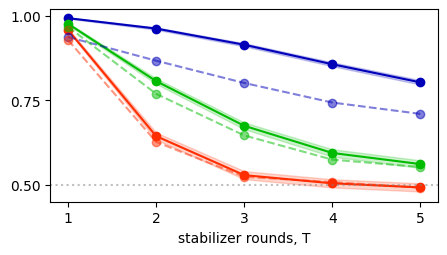

In [101]:
fig1_version = True

color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/3) for i in range(3)]

if fig1_version:
    fig = plt.figure(figsize=(5,2.5))
else:
    fig = plt.figure(figsize=(5,4))


custom_lines = [line for color in color_list for line in [Line2D([0], [0], color=color),Line2D([0], [0], linestyle='--', color=color, alpha = 0.5)]]#+[Line2D([0], [0], linestyle='--', color=color) for color in color_list]

Fid_list = np.array(Fid_list_wps)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,2],'o-',c=color_list[0])
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,2],'o-',c=color_list[1])
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,2],'o-',c=color_list[2])
if not fig1_version:
    plt.legend(custom_lines,[label for d in range(2,5) for label in [r'$d = '+str(d)+'$, QEC+PS',r'$d = '+str(d)+'$, QEC']])

plt.fill_between(Fid_list_d2[:,1],Fid_list_d2[:,2]-Fid_list_d2[:,3],Fid_list_d2[:,2]+Fid_list_d2[:,3],color=color_list[0],alpha = 0.2)
plt.fill_between(Fid_list_d3[:,1],Fid_list_d3[:,2]-Fid_list_d3[:,3],Fid_list_d3[:,2]+Fid_list_d3[:,3],color=color_list[1],alpha = 0.2)
plt.fill_between(Fid_list_d4[:,1],Fid_list_d4[:,2]-Fid_list_d4[:,3],Fid_list_d4[:,2]+Fid_list_d4[:,3],color=color_list[2],alpha = 0.2)

Fid_list = np.array(Fid_list_nops)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,2],'o--',c=color_list[0],alpha = 0.5)
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,2],'o--',c=color_list[1],alpha = 0.5)
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,2],'o--',c=color_list[2],alpha = 0.5)

plt.yticks(np.linspace(0,1,5))
plt.ylim(0.45,1.02)
plt.xticks(range(1,6))
plt.xlabel(r'stabilizer rounds, T')
plt.axhline(0.5,color='gray',linestyle = ':',alpha = 0.5)
# plt.loglog()
# if log_prep == 'X':
#     plt.title(r'Bacon-Shor only')
#     plt.ylabel(r'logical $|\!+\!\rangle$ fidelity')
#     plt.savefig(home+'/figures/BSonly_logX_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')
# elif not fig1_version:
#     plt.title(r'Bacon-Shor only')
#     plt.ylabel(r'logical $|0\rangle$ fidelity')
#     plt.savefig(home+'/figures/BSonly_logZ_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')
# else:
#     plt.title(r'Bacon-Shor code on ibm-torino')
#     plt.ylabel(r'logical $|0\rangle$ fidelity')
#     plt.savefig(home+'/figures/BSonly_logZ_fig1_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')
plt.show()

# 3CX code only

In [7]:
def only3CX(d, T,logical_prep, offset = -2+6j,
            num_qubits = -1, 
            virt_link = False,
            CXerror=0, Rerror=0,singleQerror=0):
    
    code = BS3CXheavyhex(d=d, T=T, logical_prep=[logical_prep,'Z'], logical_meas=[logical_prep,'Z'], offset=offset,
                            num_qubits=num_qubits, 
                            virt_link=virt_link,
                            CX_schedule = ['3CX0', '3CX1', '3CX2', '3CX3'],
                            CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror)
    return code

## Simulations

In [51]:
code = only3CX(d=3,T=3,logical_prep = 'Z',CXerror=0.01)

stim_circuit = build_stim_circuit(code)
stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)

stim_DEM.diagram(type="match-graph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":748,"max":[45.922779083252,45.922779083252,19],"min":[2.07722091674805,2.07722091674805,-10],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":174,"max":[43.0436096191406,12,11.5630722045898],"min":[4.95639228820801,2.07722091674805,-2.563072681427],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":8976,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":2,"byteLength":2088,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":8976,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABAQQAAQEEAAAAAAABAQQAAwEEAAEBAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAEBAxJqeQMSankCxpgdAAABAQQAAQEEAAEBAxJqeQMSankCxpgdAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAAAQQgAAQEEAAAAAAAAQQgAAwEEAAAAAAAAQQgAAQEEAAAAAAAAQQgAAwEEAAEBAAAAQQgAAQEEAAAAAAAAQQgAAwEEAAEBAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAAAQQgAAQEEAAAAAAADAQQAAQEEAAEBAAAAQQgAAQEEAAAAAAADAQQAAQEEAAEBAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAAAQQgAAQEEAAAAAAAAQQgAAQEEAAEBAAAAQQgAAQEEAAAAAAAAQQgAAQEEAAEBAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAADAQQAAwEEAAAAAAADAQQAAwEEAACDBAADAQQAAwEEAAAAAAABAQQAAwEEAAEBAAADAQQAAwEEAAAAAAABAQQAAwEEAAEBAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAADAQQAAwEEAAAAAAAAQQgAAwEEAAEBAAADAQQAAwEEAAAAAAAAQQgAAwEEAAEBAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAADAQQAAwEEAAAAAAAAQQgAAwEEAAEBAAADAQQAAwEEAAEBAAABAQQAAEEIAAEBAAADAQQAAwEEAAAAAAAAQQgAAwEEAAEBAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAADAQQAAwEEAAAAAAAAQQgAAwEEAAEBAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAADAQQAAwEEAAAAAAADAQQAAQEEAAEBAAADAQQAAwEEAAAAAAADAQQAAQEEAAEBAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAADAQQAAwEEAAAAAAADAQQAAQEEAAEBAAADAQQAAwEEAAEBAAABAQQAAEEIAAEBAAADAQQAAwEEAAAAAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAADAQQAAwEEAAAAAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAADAQQAAwEEAAEBAAADAQQAAwEEAAODAAADAQQAAwEEAAAAAAADAQQAAwEEAACDBAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAAAQQgAAwEEAAAAAA3Q1QgAAwEERuGDAAAAQQgAAwEEAAAAAAAAQQgAAwEEAAEBAAABAQQAAwEEAAEBAMPEEQAAAwEFMPOE/AABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABAQQAAwEEAAMBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAMBAMPEEQAAAwEHtsOdAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAMBAMPEEQAAAwEHtsOdAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAABAQQAAwEEAAEBAAABAQQAAQEEAAMBAAABAQQAAwEEAAEBAAABAQQAAQEEAAMBAAABAQQAAwEEAAMBAMPEEQAAAwEHtsOdAAABAQQAAwEEAAEBAAADAQQAAwEEAAMBAAABAQQAAwEEAAEBAAADAQQAAwEEAAMBAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAABAQQAAwEEAAEBAAADAQQAAwEEAAMBAAABAQQAAEEIAAEBAAABAQQAAwEEAAMBAAABAQQAAwEEAAEBAAADAQQAAwEEAAMBAAABAQQAAwEEAAMBAMPEEQAAAwEHtsOdAAABAQQAAwEEAAEBAAADAQQAAwEEAAMBAAABAQQAAwEEAAMBAMPEEQAAAwEHtsOdAAABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAABAQQAAwEEAAEBAMPEEQAAAwEFMPOE/AADAQQAAwEEAAAAAAADAQQAAwEEAACDBAABAQQAAwEEAAEBAMPEEQAAAwEFMPOE/AABAQQAAEEIAAEBAxJqeQKgsLEKxpgdAAAAQQgAAwEEAAEBA7bA3QgAAwEFMPOE/AAAQQgAAwEEAAEBAAADAQQAAQEEAAEBAAAAQQgAAwEEAAEBAAADAQQAAQEEAAEBAAADAQQAAwEEAAEBAAABAQQAAEEIAAEBAAAAQQgAAwEEAAEBAAAAQ

In [57]:
dist_list = list(range(3,11,2))
error_list = 1*np.logspace(-4,-2,10)
max_shots = 1_000_000
shot_batch = 10_000
max_num_fail = 1_000
log_prep = 'Z'

PS = False

Log_fail_d_p = []
for d in dist_list:
    T=d
    Log_fail_p =[]
    for error in error_list:
        code = only3CX(d=d, T=T, logical_prep=log_prep,
                    CXerror=error, Rerror=error,singleQerror=error)

        stim_circuit,relevant_nodes = build_stim_circuit(code, return_relevant_nodes=True)
        stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
        if PS:
            matching0 = surface_code_decoder_v2.DEM_to_postsel_matching(model=stim_DEM,relevant_nodes=relevant_nodes)
        else:
            matching0 = surface_code_decoder_v2.DEM_to_matching(model=stim_DEM,relevant_nodes=relevant_nodes)
        num_obs = 1

        num_fail = np.array([0]*num_obs)
        num_shots = 0
        num_shots2 = 0
        while num_shots<max_shots and min(num_fail)<max_num_fail:
            num_shots += shot_batch
            detector_samples = stim_circuit.compile_detector_sampler().sample(shot_batch, append_observables=True)
            correction_batch = matching0.decode_batch(detector_samples)
            num_shots2+=len(correction_batch)
            num_fail+=sum(correction_batch)

        print(d,error,min(num_fail)/num_shots2,'+/-',np.sqrt(min(num_fail))/num_shots2, num_shots2/num_shots)

        Log_fail_p.append([error,min(num_fail)/num_shots2,np.sqrt(min(num_fail))/num_shots2])

    Log_fail_d_p.append([d,Log_fail_p])

3 0.0001 1.8e-05 +/- 4.242640687119285e-06 1.0
3 0.0001668100537200059 4.2e-05 +/- 6.4807406984078604e-06 1.0
3 0.0002782559402207126 0.000164 +/- 1.2806248474865697e-05 1.0
3 0.00046415888336127773 0.00043 +/- 2.073644135332772e-05 1.0
3 0.000774263682681127 0.0011235955056179776 +/- 3.553120966481325e-05 1.0
3 0.001291549665014884 0.0033193548387096773 +/- 0.00010347751569255124 1.0
3 0.002154434690031882 0.00865 +/- 0.0002684833948931169 1.0
3 0.003593813663804626 0.0216 +/- 0.0006572670690061993 1.0
3 0.005994842503189409 0.051 +/- 0.0015968719422671312 1.0
3 0.01 0.118 +/- 0.0034351128074635333 1.0
5 0.0001 1e-06 +/- 1e-06 1.0
5 0.0001668100537200059 7e-06 +/- 2.6457513110645907e-06 1.0
5 0.0002782559402207126 1.9e-05 +/- 4.358898943540674e-06 1.0
5 0.00046415888336127773 6.9e-05 +/- 8.306623862918075e-06 1.0
5 0.000774263682681127 0.000392 +/- 1.979898987322333e-05 1.0
5 0.001291549665014884 0.001711864406779661 +/- 5.386524943074815e-05 1.0
5 0.002154434690031882 0.0075714285714

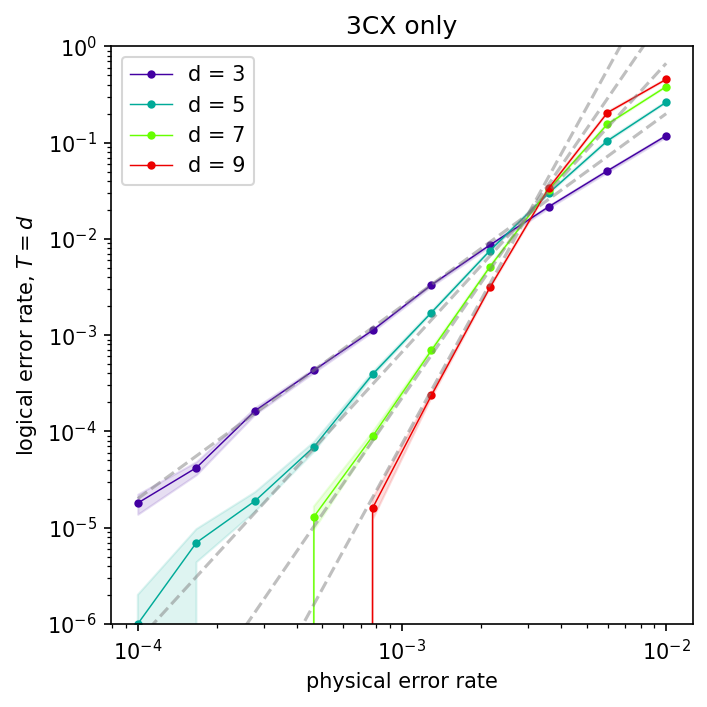

In [59]:
color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/len(dist_list)) for i in range(len(dist_list))]


fig=plt.figure(figsize=(5, 5), dpi=150)

for di,d in enumerate(dist_list):
    phys_err, log_err, _ = np.transpose(Log_fail_d_p[di][1])
    plt.plot(phys_err, log_err,'.-', c=color_list[di],linewidth = 0.7)

plt.legend(['d = '+str(d) for d in dist_list])

pth,pLatth = 3e-3,0.018

for di,d in enumerate(dist_list):
    phys_err, log_err, log_err_err = np.transpose(Log_fail_d_p[di][1])
    log_err_err = np.array(log_err_err, dtype=float)
    log_err = np.array(log_err, dtype=float)
    phys_err = np.array(phys_err, dtype=float)
    plt.fill_between(phys_err, log_err-log_err_err, log_err+log_err_err,alpha = 0.13,color=color_list[di]) 
    plt.plot(error_list, pLatth*(error_list/pth)**np.ceil((d+1)/2),'--',c='gray', alpha=0.5)

# plt.axvline(pth,linestyle=':',c="gray", alpha=0.3)

plt.title(r'3CX only')
plt.xlabel(r'physical error rate')
plt.ylabel(r'logical error rate, $T = d$')
plt.ylim(1e-6,1)
plt.loglog()
plt.savefig(home+'/figures/threshold_plot_dT3to9_3CXonly_nops.pdf',bbox_inches = 'tight')
plt.show()

## Device data

### collecting data

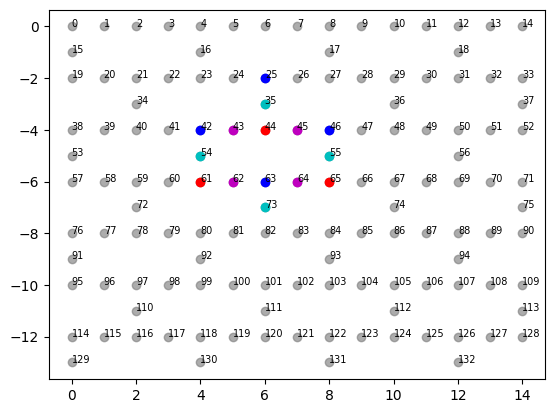

In [5]:
num_qubits = 133

d,T=2,2
code = only3CX(d=d,T=T,logical_prep = 'Z',offset = 0+4j,num_qubits=133)
qc = code.circuit
rep_delay=backend.configuration().rep_delay_range[1]
qc.barrier()
qc.delay(0.05*rep_delay,unit='s')
qc.draw(fold=-1,idle_wires=False)
init_layout = [qc.qubits[q] for q in range(qc.num_qubits)]
qc_trans = transDD(qc,backend,echo = 'XZX', qubit_list=code.qubit_index_list3CX)

code.draw_lattice()

In [102]:
# timeline_drawer(qc_trans,show_idle=False)

In [62]:
num_qubits = 133

anc_reset = True
rep_delay=backend.configuration().rep_delay_range[1]
dd='XZX'
num_shots = 10_000
shot_mutiplier = 1

res_labels = []
for d in [2,3,4]:
    for T in range(1,6):
        if d==2:
            offset_list = [2+2j]
        elif d==3:
            offset_list = [0+4j]
        elif d==4:
            offset_list = [-2+6j]

        rep_multi = int(T/2)+1
        for offset in offset_list:
            for logical_prep in ['X','Z']:
                code = onlyBS(d=d,T=T,logical_prep = logical_prep,offset = offset,num_qubits=133)

                qc = code.circuit            
                qc.barrier()
                qc.delay(rep_multi*rep_delay,unit='s')

                qc_trans = transDD(
                                    qc, backend,echo = dd, qubit_list=code.qubit_index_list3CX
                                    )

                job=backend.run([qc_trans for _ in range(shot_mutiplier)], shots=num_shots,rep_delay=rep_delay)
                res_labels.append([job.job_id(),
                                    '3CXonly_'
                                    +'d'+str(d)
                                    +'T'+str(T)
                                    +'_log'+logical_prep
                                    +'_reset'+str(anc_reset)
                                    +'_os'+int((1+np.sign(offset.real))/2)*'p'+int((1-np.sign(offset.real))/2)*'m'+str(int(abs(offset.real)))+'p'+str(int(offset.imag))
                                    +'_dd'+dd
                                    +'_optCXsched'
                                    +'_Nshots'+str(int(shot_mutiplier*num_shots))
                                    +'_'+backend.name
                                    +'_'+job.job_id()
                                    +'.json'])

res_labels

[['cq4cxa5dhsd0008kfga0',
  '3CXonly_d2T1_logX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxa5dhsd0008kfga0.json'],
 ['cq4cxand7we0008rdvpg',
  '3CXonly_d2T1_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxand7we0008rdvpg.json'],
 ['cq4cxbd7z1hg008ac640',
  '3CXonly_d2T2_logX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxbd7z1hg008ac640.json'],
 ['cq4cxcd28rp0008xxhfg',
  '3CXonly_d2T2_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxcd28rp0008xxhfg.json'],
 ['cq4cxd5ph3s0008m9k50',
  '3CXonly_d2T3_logX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxd5ph3s0008m9k50.json'],
 ['cq4cxdx28rp0008xxhgg',
  '3CXonly_d2T3_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxdx28rp0008xxhgg.json'],
 ['cq4cxed28rp0008xxhh0',
  '3CXonly_d2T4_logX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxed28rp0008xxhh0.json'],
 ['cq4cxexhbttg008r4wag',
  '3CXonly_d2T4_logZ_resetTrue_osp2p2_ddXZX

In [ ]:
folder = home+'/results/3CXonly_120224/'

for job_id, file_name in res_labels:
    results = provider.retrieve_job(job_id).result().get_counts()
    if isinstance(results,list):
        result = {}
        for res in results:
            for key in res.keys():
                if key in result:
                    result[key]+=res[key]
                else:
                    result[key]=res[key]
    else:
        result = results

    fname = folder+file_name
    with open(fname, "w") as f:
        f.write(json.dumps(result))
    print(file_name)

### plotting data

In [102]:
dist_list = list(range(2,5))
T_list = list(range(1,6))
num_shots = 10_000
folder = home+'/results/3CXonly_120224/'
CXerror, Rerror,singleQerror = 0.004, 0.0174,3e-4

log_prep = 'Z'
Fid_list_nops = []
Fid_list_wps = []
for d in dist_list:
    Log_fail_T =[]
    for T in T_list:
        code = only3CX(d=d, T=T, logical_prep=log_prep,
                    CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror)

        file_name_without_id =('3CXonly_d' + str(d) + 'T' + str(T) + '_log'+log_prep)
        for file in os.listdir(folder):
            if file.startswith(file_name_without_id):
                result = json.load(open(folder+file))
                print(file)
        
        meas_data = code.measuredict
        log_measinds = [[meas_data[(pos,T)]-len(meas_data) for pos in code.edge_qubit_pos3CX]]
        freqs,detector_samples = string2detections(job_result = result, det_measinds = code.error_sensitive_events, log_measinds = log_measinds)
        
        Fid_list_nops.append(Fidelity_yield_from_detector_samples(code,freqs,detector_samples,post_sel=False))
        Fid_list_wps.append(Fidelity_yield_from_detector_samples(code,freqs,detector_samples,post_sel=True))

3CXonly_d2T1_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxand7we0008rdvpg.json
d = 2  T = 1  F = 0.9043 +/- 0.0062  yield = 1.0
d = 2  T = 1  F = 0.9921 +/- 0.0019  yield = 0.8489
3CXonly_d2T2_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxcd28rp0008xxhfg.json
d = 2  T = 2  F = 0.8278 +/- 0.0083  yield = 1.0
d = 2  T = 2  F = 0.9694 +/- 0.0041  yield = 0.744
3CXonly_d2T3_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxdx28rp0008xxhgg.json
d = 2  T = 3  F = 0.775 +/- 0.0095  yield = 1.0
d = 2  T = 3  F = 0.9244 +/- 0.0067  yield = 0.6719
3CXonly_d2T4_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxexhbttg008r4wag.json
d = 2  T = 4  F = 0.7358 +/- 0.0103  yield = 1.0
d = 2  T = 4  F = 0.8913 +/- 0.0083  yield = 0.6273
3CXonly_d2T5_logZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq4cxg6d7we0008rdvq0.json
d = 2  T = 5  F = 0.6966 +/- 0.011  yield = 1.0
d = 2  T = 5  F = 0.8422 +/- 0.0103  yield = 

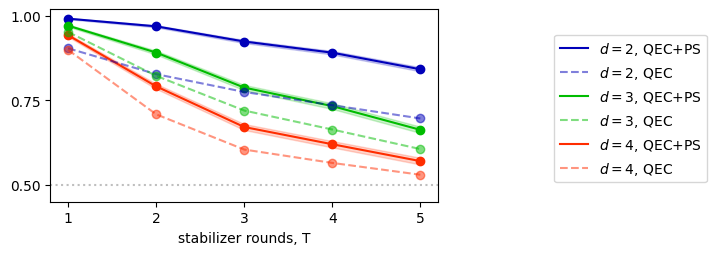

In [103]:
fig1_version = True

color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/3) for i in range(3)]

if fig1_version:
    fig = plt.figure(figsize=(5,2.5))
else:
    fig = plt.figure(figsize=(5,4))

custom_lines = [line for color in color_list for line in [Line2D([0], [0], color=color),Line2D([0], [0], linestyle='--', color=color, alpha = 0.5)]]#+[Line2D([0], [0], linestyle='--', color=color) for color in color_list]

Fid_list = np.array(Fid_list_wps)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,2],'o-',c=color_list[0])
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,2],'o-',c=color_list[1])
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,2],'o-',c=color_list[2])
if fig1_version:
    plt.legend(custom_lines,[label for d in range(2,5) for label in [r'$d = '+str(d)+'$, QEC+PS',r'$d = '+str(d)+'$, QEC']], loc = [1.3,0.1])
else:
    plt.legend(custom_lines,[label for d in range(2,5) for label in [r'$d = '+str(d)+'$, QEC+PS',r'$d = '+str(d)+'$, QEC']])
plt.fill_between(Fid_list_d2[:,1],Fid_list_d2[:,2]-Fid_list_d2[:,3],Fid_list_d2[:,2]+Fid_list_d2[:,3],color=color_list[0],alpha = 0.2)
plt.fill_between(Fid_list_d3[:,1],Fid_list_d3[:,2]-Fid_list_d3[:,3],Fid_list_d3[:,2]+Fid_list_d3[:,3],color=color_list[1],alpha = 0.2)
plt.fill_between(Fid_list_d4[:,1],Fid_list_d4[:,2]-Fid_list_d4[:,3],Fid_list_d4[:,2]+Fid_list_d4[:,3],color=color_list[2],alpha = 0.2)

Fid_list = np.array(Fid_list_nops)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,2],'o--',c=color_list[0],alpha = 0.5)
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,2],'o--',c=color_list[1],alpha = 0.5)
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,2],'o--',c=color_list[2],alpha = 0.5)

plt.yticks(np.linspace(0,1,5))
plt.ylim(0.45,1.02)
plt.xticks(range(1,6))
plt.xlabel(r'stabilizer rounds, T')
plt.axhline(0.5,color='gray',linestyle = ':',alpha = 0.5)
# plt.loglog()
# if log_prep == 'X':
#     plt.title(r'3CX only')
#     plt.ylabel(r'logical $|\!+\!\rangle$ fidelity')
#     plt.savefig(home+'/figures/3CXonly_logX_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')
# elif not fig1_version:
#     plt.title(r'3CX only')
#     plt.ylabel(r'logical $|0\rangle$ fidelity')
#     plt.savefig(home+'/figures/3CXonly_logZ_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')
# else:
#     plt.title(r'3CX code on ibm-torino')
#     plt.ylabel(r'logical $|0\rangle$ fidelity')
#     plt.savefig(home+'/figures/3CXonly_logZ_fig1_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')

plt.show()

# 3CX + BS codes, no entanglement

## Simulations

Note that the post-selection strategy --that is based on the ambiguity of matching to different boundaries-- does not work here, because there are internal edges of the decoding graph that imply logical flips.

In [87]:
code = BS3CXheavyhex(d=3,T=3,logical_prep = ['Z','X'],logical_meas= ['Z','X'], num_qubits=-1, CXerror=0.01, Rerror=0.1, singleQerror=0.4)

stim_circuit = build_stim_circuit(code, simplify=True)
stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)

stim_DEM.diagram(type="match-graph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":6626,"max":[72.9146041870117,42.6208457946777,13.0710678100586],"min":[2.01725578308105,5.37915325164795,-9.4868335723877],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":1398,"max":[60.704948425293,36,12.4874286651611],"min":[2.96460247039795,2.15268135070801,-3.48742914199829],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":79512,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":2,"byteLength":16776,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":79512,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAQEEAAAAAAADAQQAAwEEAAAAAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAAAAAABAQQAAwEEAAEBAAABAQQAAQEEAAAAAAABAQQAAwEEAAEBAAABAQQAAQEEAAAAAAABAQQAAwEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAQEEAAAAAAABAQQAAwEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAQEEAAAAAAABAQQAAwEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABMQgAAqEEAAAAAAABMQgAAqEEAAEBAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABMQgAAqEEAAAAAAABMQgAAqEEAAEBAAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAAAAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAABAQQAAQEEAAEBADLw9QAPw90AB/B1AAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAADAQQAAwEEAAEBAhvpgQQAAwEHMpfI/AAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAADAQQAAwEEAAEBAhvpgQQAAwEHMpfI/AABMQgAAqEEAAEBAAAB8QgAAqEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAADAQQAAwEEAAEBAhvpgQQAAwEHMpfI/AABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAABMQgAAqEEAAAAAAABMQgAAqEEAAEBAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAABMQgAAqEEAAAAAAABMQgAAqEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAABMQgAAqEEAAAAAAAB8QgAAqEEAAAAAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAABMQgAAqEEAAAAAAAB8QgAAqEEAAAAAAABkQgAAcEEAAEBAdB2EQhcdLUG6aBNAAAAQQgAAQEEAAAAAAADAQQAAwEEAAAAAAABMQgAAqEEAAAAAA

In [75]:
dist_list = list(range(3,11,2))
error_list = 1*np.logspace(-4,-2,10)
max_shots = 1_000_000
shot_batch = 10_000
max_num_fail = 1_000
log_prep = ['Z','Z']

PS = False

Log_fail_d_p3CX = []
Log_fail_d_pBS = []
for d in dist_list:
    T=d
    Log_fail_p3CX =[]
    Log_fail_pBS =[]
    for error in error_list:
        code = BS3CXheavyhex(d=d, T=T, 
                             logical_prep=log_prep,logical_meas=log_prep,
                             num_qubits=-1,
                             CX_schedule = ['3CX0', 'BSZ0', 'BSZ1', '3CX1', '3CX2', 'BSX0', 'BSX1', '3CX3'],
                             CXerror=error, Rerror=error,singleQerror=error)

        stim_circuit,relevant_nodes = build_stim_circuit(code, simplify=True, return_relevant_nodes=True)
        stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
        if PS:
            matching0 = surface_code_decoder_v2.DEM_to_postsel_matching(model=stim_DEM,relevant_nodes=relevant_nodes)
        else:
            matching0 = surface_code_decoder_v2.DEM_to_matching(model=stim_DEM,relevant_nodes=relevant_nodes)
        num_obs = 2

        num_fail = np.array([0]*num_obs)
        num_shots = 0
        num_shots2 = 0
        while num_shots<max_shots and min(num_fail)<max_num_fail:
            num_shots += shot_batch
            detector_samples = stim_circuit.compile_detector_sampler().sample(shot_batch, append_observables=True)
            correction_batch = matching0.decode_batch(detector_samples)
            num_shots2+=len(correction_batch)
            num_fail+=sum(correction_batch)

        print(d,error,'3CX: ',num_fail[0]/num_shots2,'+/-',np.sqrt(num_fail[0])/num_shots2,'BS: ',num_fail[1]/num_shots2,'+/-',np.sqrt(num_fail[1])/num_shots2, num_shots2/num_shots)

        Log_fail_p3CX.append([error,num_fail[0]/num_shots2,np.sqrt(num_fail[0])/num_shots2])
        Log_fail_pBS.append([error,num_fail[1]/num_shots2,np.sqrt(num_fail[1])/num_shots2])

    Log_fail_d_p3CX.append([d,Log_fail_p3CX])
    Log_fail_d_pBS.append([d,Log_fail_pBS])

3 0.0001 3CX:  5.1e-05 +/- 7.141428428542851e-06 BS:  4.2e-05 +/- 6.4807406984078604e-06 1.0
3 0.0001668100537200059 3CX:  0.000104 +/- 1.019803902718557e-05 BS:  0.000125 +/- 1.1180339887498949e-05 1.0
3 0.0002782559402207126 3CX:  0.000361 +/- 1.9e-05 BS:  0.000304 +/- 1.7435595774162695e-05 1.0
3 0.00046415888336127773 3CX:  0.00099 +/- 3.1464265445104545e-05 BS:  0.000907 +/- 3.0116440692751193e-05 1.0
3 0.000774263682681127 3CX:  0.002565 +/- 8.007808689023482e-05 BS:  0.002565 +/- 8.007808689023482e-05 1.0
3 0.001291549665014884 3CX:  0.007266666666666667 +/- 0.00022010098692292236 BS:  0.006753333333333333 +/- 0.00021218440617119398 1.0
3 0.002154434690031882 3CX:  0.019433333333333334 +/- 0.0005691123692987957 BS:  0.016716666666666668 +/- 0.0005278362540704372 1.0
3 0.003593813663804626 3CX:  0.046 +/- 0.0012382783747337807 BS:  0.046966666666666664 +/- 0.0012512216252748972 1.0
3 0.005994842503189409 3CX:  0.1035 +/- 0.002274862633215465 BS:  0.1011 +/- 0.0022483327155917118 

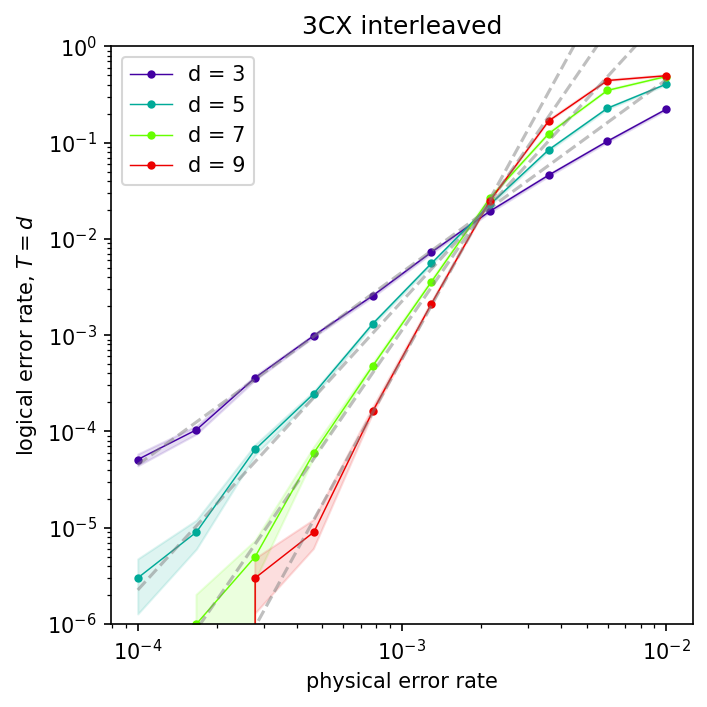

In [79]:
color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/len(dist_list)) for i in range(len(dist_list))]
Log_fail_d_p = Log_fail_d_p3CX

fig=plt.figure(figsize=(5, 5), dpi=150)

for di,d in enumerate(dist_list):
    phys_err, log_err, _ = np.transpose(Log_fail_d_p[di][1])
    plt.plot(phys_err, log_err,'.-', c=color_list[di],linewidth = 0.7)

plt.legend(['d = '+str(d) for d in dist_list])

pth,pLatth = 2e-3,0.018

for di,d in enumerate(dist_list):
    phys_err, log_err, log_err_err = np.transpose(Log_fail_d_p[di][1])
    log_err_err = np.array(log_err_err, dtype=float)
    log_err = np.array(log_err, dtype=float)
    phys_err = np.array(phys_err, dtype=float)
    plt.fill_between(phys_err, log_err-log_err_err, log_err+log_err_err,alpha = 0.13,color=color_list[di]) 
    plt.plot(error_list, pLatth*(error_list/pth)**np.ceil((d+1)/2),'--',c='gray', alpha=0.5)

# plt.axvline(pth,linestyle=':',c="gray", alpha=0.3)

plt.title(r'3CX interleaved')
plt.xlabel(r'physical error rate')
plt.ylabel(r'logical error rate, $T = d$')
plt.ylim(1e-6,1)
plt.loglog()
# plt.savefig(home+'/figures/threshold_plot_dT3to9_3CXinterleaved_nops.pdf',bbox_inches = 'tight')
plt.show()

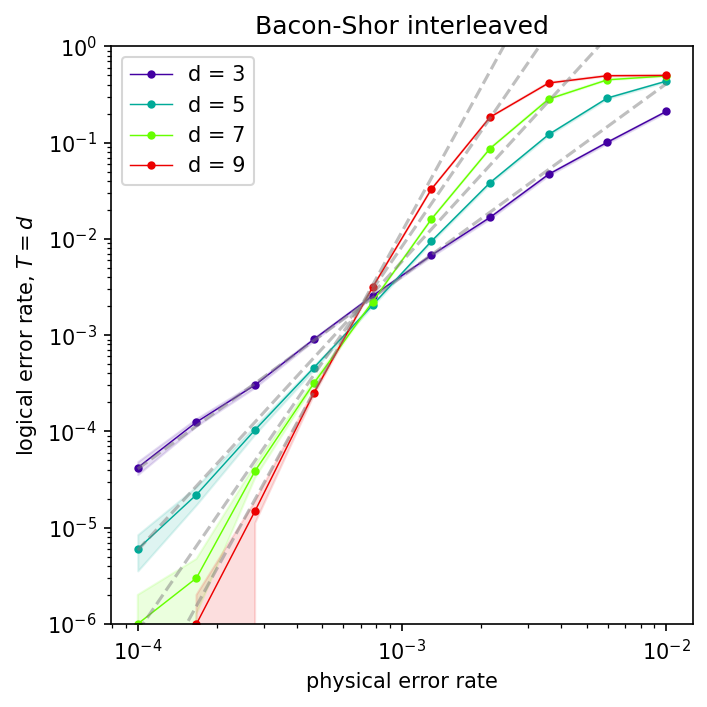

In [89]:
color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/len(dist_list)) for i in range(len(dist_list))]
Log_fail_d_p = Log_fail_d_pBS

fig=plt.figure(figsize=(5, 5), dpi=150)

for di,d in enumerate(dist_list):
    phys_err, log_err, _ = np.transpose(Log_fail_d_p[di][1])
    plt.plot(phys_err, log_err,'.-', c=color_list[di],linewidth = 0.7)

plt.legend(['d = '+str(d) for d in dist_list])

pth,pLatth = 7e-4,0.002

for di,d in enumerate(dist_list):
    phys_err, log_err, log_err_err = np.transpose(Log_fail_d_p[di][1])
    log_err_err = np.array(log_err_err, dtype=float)
    log_err = np.array(log_err, dtype=float)
    phys_err = np.array(phys_err, dtype=float)
    plt.fill_between(phys_err, log_err-log_err_err, log_err+log_err_err,alpha = 0.13,color=color_list[di]) 
    plt.plot(error_list, pLatth*(error_list/pth)**np.ceil((d+1)/2),'--',c='gray', alpha=0.5)

# plt.axvline(pth,linestyle=':',c="gray", alpha=0.3)

plt.title(r'Bacon-Shor interleaved')
plt.xlabel(r'physical error rate')
plt.ylabel(r'logical error rate, $T = d$')
plt.ylim(1e-6,1)
plt.loglog()
# plt.savefig(home+'/figures/threshold_plot_dT3to9_BSinterleaved_nops.pdf',bbox_inches = 'tight')
plt.show()

## Device data

### collecting data

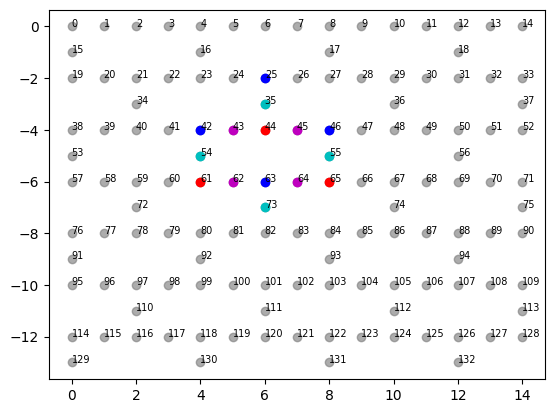

In [12]:
log_prep = ['X','Z']
num_qubits = 133
optimal_CX_schedule = ['3CX0', 'BSZ0', 'BSZ1', '3CX1', '3CX2', 'BSX0', 'BSX1', '3CX3'] 


d,T=2,2
code = BS3CXheavyhex(d=d,T=T,logical_prep = log_prep, logical_meas = log_prep, offset = 0+4j,num_qubits=133,CX_schedule=optimal_CX_schedule)
qc = code.circuit
rep_delay=backend.configuration().rep_delay_range[1]
qc.barrier()
qc.delay(0.01*rep_delay,unit='s')
qc.draw(fold=-1,idle_wires=False)
init_layout = [qc.qubits[q] for q in range(qc.num_qubits)]
qc_trans = transDD(transpile(qc,backend,optimization_level=3,initial_layout=init_layout),backend,echo = 'XZX', qubit_list=code.qubit_index_list3CX+code.qubit_index_listBS)

code.draw_lattice()

In [65]:
# timeline_drawer(qc_trans,show_idle=False)

In [ ]:
num_qubits = 133

anc_reset = True
rep_delay=backend.configuration().rep_delay_range[1]
dd='XZX'
num_shots = 10_000
shot_mutiplier = 1

res_labels = []
for d in [2,3,4]:
    for T in range(1,6):
        if d==2:
            offset_list = [2+2j]
        elif d==3:
            offset_list = [0+4j]
        elif d==4:
            offset_list = [-2+6j]

        rep_multi = int(T/2)+1
        for offset in offset_list:
            for logical_prep in [['X','Z'],['Z','X']]:
                code = BS3CXheavyhex(d=d,T=T,
                                     logical_prep = logical_prep, logical_meas = logical_prep,
                                     offset = offset,num_qubits=133,
                                     CX_schedule=optimal_CX_schedule)

                qc = code.circuit
                qc.barrier()
                qc.delay(rep_multi*rep_delay,unit='s')

                init_layout = [qc.qubits[q] for q in range(qc.num_qubits)]
                qc_trans = transDD(
                                    transpile(qc,backend,optimization_level=3,initial_layout=init_layout)
                                    , backend,echo = dd, qubit_list=code.qubit_index_list3CX+code.qubit_index_listBS
                                    )

                job=backend.run([qc_trans for _ in range(shot_mutiplier)], shots=num_shots,rep_delay=rep_delay)
                res_labels.append([job.job_id(),
                                    '3CXandBS_'
                                    +'d'+str(d)
                                    +'T'+str(T)
                                    +'_logs'+str(logical_prep[0])+str(logical_prep[1])
                                    +'_reset'+str(anc_reset)
                                    +'_os'+int((1+np.sign(offset.real))/2)*'p'+int((1-np.sign(offset.real))/2)*'m'+str(int(abs(offset.real)))+'p'+str(int(offset.imag))
                                    +'_dd'+dd
                                    +'_optCXsched'
                                    +'_Nshots'+str(int(shot_mutiplier*num_shots))
                                    +'_'+backend.name
                                    +'_'+job.job_id()
                                    +'.json'])

res_labels

In [83]:
folder = home+'/results/3CX_BS_120224/'

for job_id, file_name in res_labels:
    results = provider.retrieve_job(job_id).result().get_counts()
    if isinstance(results,list):
        result = {}
        for res in results:
            for key in res.keys():
                if key in result:
                    result[key]+=res[key]
                else:
                    result[key]=res[key]
    else:
        result = results

    fname = folder+file_name
    with open(fname, "w") as f:
        f.write(json.dumps(result))
    print(file_name)

3CXandBS_d2T1_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521c5dhsd0008kgn20.json
3CXandBS_d2T1_logsZX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521d5hbttg008r6540.json
3CXandBS_d2T2_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521dxph3s0008masc0.json
3CXandBS_d2T2_logsZX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521enph3s0008mascg.json
3CXandBS_d2T3_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521fddhsd0008kgn2g.json
3CXandBS_d2T3_logsZX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521g628rp0008xyt40.json
3CXandBS_d2T4_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521gy7z1hg008znnt0.json
3CXandBS_d2T4_logsZX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521hpdhsd0008kgn30.json
3CXandBS_d2T5_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521jpdhsd0008kgn3g.json
3CXandBS_d2T5_logsZX_resetTrue_osp2p2_ddXZX_optCXsched_Nshots100

### plotting data

In [139]:
dist_list = list(range(2,5))
T_list = list(range(1,6))
num_shots = 10_000
folder = home+'/results/3CX_BS_120224/'
CXerror, Rerror,singleQerror = 0.004, 0.0174,3e-4

log_prep = ['X','Z']
# log_prep = ['Z','X']
Fid_listBS_nops = []
Fid_listBS_wps = []
Fid_list3CX_nops = []
Fid_list3CX_wps = []
for d in dist_list:
    Log_fail_T =[]
    for T in T_list:
        code = BS3CXheavyhex(d=d, T=T,
                            logical_prep=log_prep,logical_meas=log_prep,
                            num_qubits=-1,
                            CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror)

        file_name_without_id =('3CXandBS_d' + str(d) + 'T' + str(T) + '_logs'+str(log_prep[0])+str(log_prep[1]))
        for file in os.listdir(folder):
            if file.startswith(file_name_without_id):
                result = json.load(open(folder+file))
                print(file)

        meas_data = code.measuredict
        log_measinds = [[meas_data[(pos,T)]-len(meas_data) for pos in code.edge_qubit_pos3CX]]
        log_measinds += [[meas_data[(pos,T)]-len(meas_data) for pos in code.edge_qubit_posBS]]
        freqs,detector_samples = string2detections(job_result = result, det_measinds = code.error_sensitive_events, log_measinds = log_measinds)
        
        _,_,Fid_nops, Fid_nops_err, yield_nops = Fidelity_yield_from_detector_samples(code,freqs,detector_samples,post_sel=False)
        _,_,Fid_wps, Fid_wps_err, yield_wps = Fidelity_yield_from_detector_samples(code,freqs,detector_samples)

        Fid_list3CX_nops.append([d,T,Fid_nops[0],Fid_nops_err, yield_nops])
        Fid_list3CX_wps.append([d,T,Fid_wps[0], Fid_wps_err, yield_wps])

        Fid_listBS_nops.append([d,T,Fid_nops[1],Fid_nops_err, yield_nops])
        Fid_listBS_wps.append([d,T,Fid_wps[1], Fid_wps_err, yield_wps])

3CXandBS_d2T1_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521c5dhsd0008kgn20.json
d = 2  T = 1  F = [0.8688 0.9256] +/- 0.0055  yield = 1.0
d = 2  T = 1  F = [0.9862 0.995 ] +/- 0.0017  yield = 0.679
3CXandBS_d2T2_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521dxph3s0008masc0.json
d = 2  T = 2  F = [0.7294 0.8245] +/- 0.0084  yield = 1.0
d = 2  T = 2  F = [0.8241 0.8906] +/- 0.0084  yield = 0.6215
3CXandBS_d2T3_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521fddhsd0008kgn2g.json
d = 2  T = 3  F = [0.6398 0.7466] +/- 0.0101  yield = 1.0
d = 2  T = 3  F = [0.7313 0.8182] +/- 0.012  yield = 0.505
3CXandBS_d2T4_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521gy7z1hg008znnt0.json
d = 2  T = 4  F = [0.5796 0.6816] +/- 0.0113  yield = 1.0
d = 2  T = 4  F = [0.6302 0.7289] +/- 0.0143  yield = 0.5305
3CXandBS_d2T5_logsXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots10000_ibm_torino_cq521jpdhsd0008kgn3g.json
d = 2  

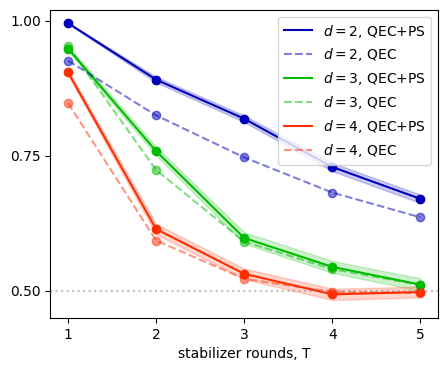

In [142]:
# Fid_list_nops = Fid_list3CX_nops
# Fid_list_wps = Fid_list3CX_wps
Fid_list_nops = Fid_listBS_nops
Fid_list_wps = Fid_listBS_wps

color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/3) for i in range(3)]
custom_lines = [line for color in color_list for line in [Line2D([0], [0], color=color),Line2D([0], [0], linestyle='--', color=color, alpha = 0.5)]]

fig = plt.figure(figsize=(5,4))

Fid_list = np.array(Fid_list_wps)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,2],'o-',c=color_list[0])
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,2],'o-',c=color_list[1])
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,2],'o-',c=color_list[2])
plt.legend(custom_lines,[label for d in range(2,5) for label in [r'$d = '+str(d)+'$, QEC+PS',r'$d = '+str(d)+'$, QEC']])
plt.fill_between(Fid_list_d2[:,1],Fid_list_d2[:,2]-Fid_list_d2[:,3],Fid_list_d2[:,2]+Fid_list_d2[:,3],color=color_list[0],alpha = 0.2)
plt.fill_between(Fid_list_d3[:,1],Fid_list_d3[:,2]-Fid_list_d3[:,3],Fid_list_d3[:,2]+Fid_list_d3[:,3],color=color_list[1],alpha = 0.2)
plt.fill_between(Fid_list_d4[:,1],Fid_list_d4[:,2]-Fid_list_d4[:,3],Fid_list_d4[:,2]+Fid_list_d4[:,3],color=color_list[2],alpha = 0.2)

Fid_list = np.array(Fid_list_nops)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,2],'o--',c=color_list[0],alpha = 0.5)
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,2],'o--',c=color_list[1],alpha = 0.5)
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,2],'o--',c=color_list[2],alpha = 0.5)

plt.yticks(np.linspace(0,1,5))
plt.ylim(0.45,1.02)
plt.xticks(range(1,6))
plt.xlabel(r'stabilizer rounds, T')
plt.axhline(0.5,color='gray',linestyle = ':',alpha = 0.5)
# plt.loglog()
# if Fid_list_nops == Fid_list3CX_nops:
#     plt.title(r'3CX interleaved')
#     if log_prep[0] == 'X':
#         plt.ylabel(r'logical $|\!+\!\rangle$ fidelity')
#         plt.savefig(home+'/figures/3CXinterleaved_logX_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')
#     else:
#         plt.ylabel(r'logical $|0\rangle$ fidelity')
#         plt.savefig(home+'/figures/3CXinterleaved_logZ_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')
# else:
#     plt.title(r'Bacon-Shor interleaved')
#     if log_prep[1] == 'X':
#         plt.ylabel(r'logical $|\!+\!\rangle$ fidelity')
#         plt.savefig(home+'/figures/BSinterleaved_logX_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')
#     else:
#         plt.ylabel(r'logical $|0\rangle$ fidelity')
#         plt.savefig(home+'/figures/BSinterleaved_logZ_d234_T1to6_torino_data.pdf',bbox_inches = 'tight')

plt.show()

# 3CX + BS with Bell state preparation and measurement

## Simulation

In [75]:
code = BS3CXheavyhex(d=3,T=3,logical_prep = ['X','Z'],logical_meas = ['X','Z'], log_gate=['CX','LSXZ'], log_round=[0,3], num_qubits=-1, CXerror=0.01)

stim_circuit,relevant_nodes = build_stim_circuit(code,simplify=True,return_relevant_nodes=True)
stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)

stim_DEM.diagram(type="match-graph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":7062,"max":[72.9437866210938,45.2035789489746,22.466625213623],"min":[0,0,-13.466625213623],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":2486,"max":[66.9146041870117,42.7719917297363,23.647102355957],"min":[-8.42023277282715,-4.64990568161011,-14.647102355957],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":84744,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":2,"byteLength":29832,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":84744,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AABAQQAAwEEAAEBAtPIdQKp210GrEhFAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABAQQAAwEEAAMBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABAQQAAwEEAAMBAAABMQgAAqEEAAEBAAABMQgAAqEEAAMBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABAQQAAwEEAAMBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABAQQAAwEEAAMBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABAQQAAwEEAAMBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABMQgAAqEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABMQgAAqEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABMQgAAqEEAABDBAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABMQgAAqEEAABDBAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAEEIAAEBAAABMQgAAqEEAABDBAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAMBAAABMQgAAqEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAMBAAABMQgAAqEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAMBAAABMQgAAqEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAAcEEAAMBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABMQgAAqEEAAEBAAABMQgAAqEEAAMBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABMQgAAqEEAAEBAAABMQgAAqEEAABDBAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABMQgAAqEEAAEBAAABMQgAAqEEAABDBAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABMQgAAqEEAAEBAAABMQgAAqEEAABDBAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAAcEEAAMBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAAcEEAAMBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAAcEEAABDBAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABkQgAAcEEAAEBAAABkQgAAcEEAABDBAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAEBAAADAQQAAQEEAAEBAAABAQQAAwEEAAEBAAABAQQAAQEEAAMBAAABAQQAAwEEAAEBAAABAQQAAQEEAAMBAAABAQQAAwEEAAMBAAABMQgAAqEEAAEBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAABAQQAAQEEAAMBAAABAQQAAwEEAAEBAAABAQQAAQEEAAMBAAABkQgAAcEEAAEBAAABkQgAA2EEAAEBAAABAQQAAwEEAAEBAAABAQQAAQEEAAMBAA

In [94]:
dist_list = list(range(2,7,1))
error_list = 1*np.logspace(-4,-2,5)
max_shots = 1_000_000
shot_batch = 10_000
max_num_fail = 1_000

log_prep = ['X','Z']


pauliX = np.array([[0,1],[1,0]])
pauliY = np.array([[0,-1j],[1j,0]])
pauliZ = np.array([[1,0],[0,-1]])
densmat_Bell = (np.identity(4)+np.kron(pauliX,pauliX)-np.kron(pauliY,pauliY)+np.kron(pauliZ,pauliZ))/4


Log_fail_d_p = []
for d in dist_list:
    T=d
    Log_fail_p =[]
    for error in error_list:
        code = BS3CXheavyhex(d=d, T=T, 
                             logical_prep=log_prep,logical_meas=log_prep,
                             log_gate = ['CX','LSXZ'], log_round = [0,T],
                             num_qubits=-1,
                             CXerror=error, Rerror=error,singleQerror=error)

        stim_circuit,relevant_nodes = build_stim_circuit(code,simplify=True,return_relevant_nodes=True)
        stim_DEM = stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
        matching0 = surface_code_decoder_v2.DEM_to_postsel_matching(stim_DEM,relevant_nodes=relevant_nodes)
        num_obs = 2

        num_correct_parity = 0
        num_fail = np.array([0]*num_obs)
        num_shots = 0
        num_shots2 = 0
        XXYYZZ_list = []
        while num_shots<=max_shots and min(num_fail)<max_num_fail:
            num_shots += shot_batch
            detector_samples = stim_circuit.compile_detector_sampler().sample(shot_batch, append_observables=True)
            unambig_correction_batch = matching0.decode_batch(detector_samples)
            num_shots-=(shot_batch-len(unambig_correction_batch))
            num_fail+=sum(unambig_correction_batch)
            XXYYZZ_list.append(np.array([sum(unambig_correction_batch)[0], sum([1-(sum(corr)%2) for corr in unambig_correction_batch]), sum(unambig_correction_batch)[1]]))

        print(d,error,'XX: ',num_fail[0]/num_shots,'+/-',np.sqrt(num_fail[0])/num_shots,'ZZ: ',num_fail[1]/num_shots,'+/-',np.sqrt(num_fail[1])/num_shots)

        XXYYZZ_expval = sum(XXYYZZ_list)/num_shots
        densmat = (np.identity(4)+sum([(1-2*exp)*np.kron(pauli,pauli) for exp,pauli in zip(XXYYZZ_expval,[pauliX,pauliY,pauliZ])]))/4
        Fid = np.trace(densmat_Bell@densmat).real  
        print(1-Fid)
        Log_fail_p.append([error,1-Fid,np.sqrt(max(num_fail))/num_shots])

    Log_fail_d_p.append([d,Log_fail_p])

2 0.0001 XX:  6.9988661836782445e-06 +/- 2.645322768776049e-06 ZZ:  4.9991901311987455e-06 +/- 2.2357057931612977e-06
9.998380262388196e-06
2 0.00031622776601683794 XX:  8.527169445763731e-05 +/- 9.195083289123302e-06 ZZ:  6.84156618322904e-05 +/- 8.23627781410778e-06
0.00014575510564274197
2 0.001 XX:  0.0007070747138975387 +/- 2.6480156137207578e-05 ZZ:  0.0005632797159800868 +/- 2.3634691857857125e-05
0.0011811023622047
2 0.0031622776601683794 XX:  0.007634283215509074 +/- 0.0002153280604090547 ZZ:  0.006292058401962928 +/- 0.00019548474284467946
0.012638777542939073
2 0.01 XX:  0.08015146733985484 +/- 0.002053142031760086 ZZ:  0.06574103292310929 +/- 0.0018594372072855464
0.1282739034395708
3 0.0001 XX:  5.447809980387884e-05 +/- 7.345825479006778e-06 ZZ:  3.763941440995265e-05 +/- 6.105919296112221e-06
9.112700330826673e-05
3 0.00031622776601683794 XX:  0.00042844560728934095 +/- 2.0637498724630447e-05 ZZ:  0.0004145285806024482 +/- 2.0299551928067004e-05
0.0008320393812091265
3 0

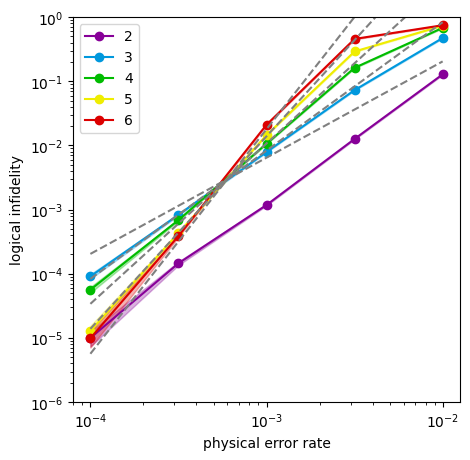

In [95]:
color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/len(dist_list)) for i in range(len(dist_list))]

plt.figure(figsize=(5,5))

for di,d in enumerate(dist_list):
    phys_err, log_err, loeg_err_err = np.transpose(Log_fail_d_p[di][1])
    plt.plot(phys_err, log_err,'-o', c=color_list[di])
plt.legend(dist_list)

for di,d in enumerate(dist_list):
    phys_err, log_err, loeg_err_err = np.transpose(Log_fail_d_p[di][1])
    plt.fill_between(phys_err, log_err-loeg_err_err, log_err+loeg_err_err,alpha = 0.3,color=color_list[di])   
    plt.plot(error_list, 0.003*(error_list/6e-4)**(((d+1)/2)),'--',c="gray")

plt.xlabel("physical error rate")
plt.ylabel("logical infidelity")
plt.ylim(1e-6,1)
plt.loglog()
plt.show()

## Device data

### collecting data

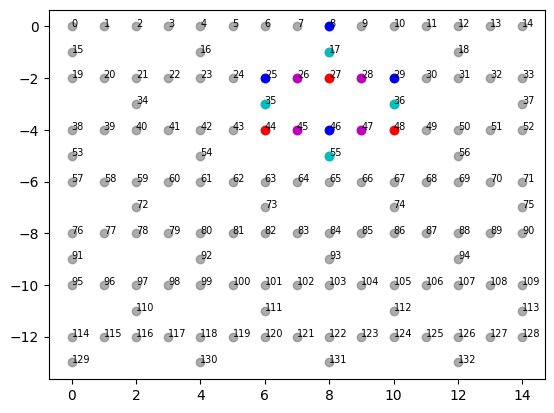

In [67]:
logical_prep = ['X','Z']
num_qubits = 133
optimal_CX_schedule = ['3CX0', 'BSZ0', 'BSZ1', '3CX1', '3CX2', 'BSX0', 'BSX1', '3CX3'] 


d,T=2,2
offset = 2+2j
log_gate = ['CX','LSXZ']
log_round = [0,T]
code = BS3CXheavyhex(d=d, T=T, 
                        logical_prep=logical_prep, logical_meas=logical_prep,
                        log_gate = log_gate, log_round=log_round,
                        num_qubits = num_qubits,
                        offset = offset,
                        CX_schedule = optimal_CX_schedule
                        )
qc = code.circuit
rep_delay=backend.configuration().rep_delay_range[1]
qc.barrier()
qc.delay(0.01*rep_delay,unit='s')
qc.draw(fold=-1,idle_wires=False)
init_layout = [qc.qubits[q] for q in range(qc.num_qubits)]
qc_trans = transDD(transpile(qc,backend,optimization_level=3,initial_layout=init_layout),backend,echo = 'XZX', qubit_list=code.qubit_index_list3CX+code.qubit_index_listBS)

code.draw_lattice()

In [69]:
# timeline_drawer(qc_trans,show_idle=False)

In [ ]:
num_qubits = 133

anc_reset = True
rep_delay=backend.configuration().rep_delay_range[1]
optimal_CX_schedule = ['3CX0', 'BSZ0', 'BSZ1', '3CX1', '3CX2', 'BSX0', 'BSX1', '3CX3'] 
dd='XZX'
num_shots = 50_000
shot_mutiplier = 1

res_labels = []
for d in [2,3,4]:
    for T in range(1,6):
        log_gate = ['CX','LSXZ']
        log_round = [0,T]
        if d==2:
            offset_list = [2+2j]
        elif d==3:
            offset_list = [0+4j]
        elif d==4:
            offset_list = [-2+6j]

        rep_multi = int(T/2)+1
        for offset in offset_list:
            for logical_prep in [['X','Z']]:
                code = BS3CXheavyhex(d=d, T=T, 
                                        logical_prep=logical_prep, logical_meas=logical_prep,
                                        log_gate = log_gate, log_round=log_round,
                                        num_qubits = num_qubits,
                                        offset = offset,
                                        CX_schedule = optimal_CX_schedule
                                        )
                qc = code.circuit

                qc.barrier()
                qc.delay(rep_multi*rep_delay,unit='s')

                init_layout = [qc.qubits[q] for q in range(qc.num_qubits)]
                qc_trans = transDD(
                                    transpile(qc,backend,optimization_level=3,initial_layout=init_layout),
                                    backend, echo = dd, qubit_list=code.qubit_index_list3CX+code.qubit_index_listBS
                                    )

                job=backend.run([qc_trans for _ in range(shot_mutiplier)], shots=num_shots,rep_delay=rep_delay)
                res_labels.append([job.job_id(),
                                    'd'+str(d)
                                    +'T'+str(T)
                                    +'_logs'+str(logical_prep[0])+str(logical_prep[1])
                                    +'_Lgate'+log_gate[-1]
                                    +'_reset'+str(anc_reset)
                                    +'_os'+int((1+np.sign(offset.real))/2)*'p'+int((1-np.sign(offset.real))/2)*'m'+str(int(abs(offset.real)))+'p'+str(int(offset.imag))
                                    +'_dd'+dd
                                    +'_optCXsched'
                                    +'_Nshots'+str(int(shot_mutiplier*num_shots))
                                    +'_'+backend.name
                                    +'_'+job.job_id()
                                    +'.json'])

res_labels

In [82]:
folder = home+'/results/3CX_BS_Bell_LSXZ_120224/'

for job_id, file_name in res_labels:
    results = provider.retrieve_job(job_id).result().get_counts()
    if isinstance(results,list):
        result = {}
        for res in results:
            for key in res.keys():
                if key in result:
                    result[key]+=res[key]
                else:
                    result[key]=res[key]
    else:
        result = results

    fname = folder+file_name
    with open(fname, "w") as f:
        f.write(json.dumps(result))
    print(file_name)

d2T1_logsXZ_LgateLSXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d09hhbttg008r4wng.json
d2T2_logsXZ_LgateLSXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d0ah28rp0008xxhz0.json
d2T3_logsXZ_LgateLSXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d0b928rp0008xxhzg.json
d2T4_logsXZ_LgateLSXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d0c128rp0008xxj00.json
d2T5_logsXZ_LgateLSXZ_resetTrue_osp2p2_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d0d1d7we0008rdvxg.json
d3T1_logsXZ_LgateLSXZ_resetTrue_os0p4_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d0e1d7we0008rdvy0.json
d3T2_logsXZ_LgateLSXZ_resetTrue_os0p4_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d0eh28rp0008xxj1g.json
d3T3_logsXZ_LgateLSXZ_resetTrue_os0p4_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d0g228rp0008xxj20.json
d3T4_logsXZ_LgateLSXZ_resetTrue_os0p4_ddXZX_optCXsched_Nshots50000_ibm_torino_cq4d0hjd7we0008rdvz0.json
d3T5_logsXZ_LgateLSXZ_resetTrue_os0p4_ddXZX_optCXsched_Nsho

### plotting data

In [ ]:
dist_list = list(range(2,5))
T_list = list(range(1,6))
num_shots = 50_000
# folder = home+'/results/3CX_BS_Bell_LSXZ_130124/'
folder = home+'/results/3CX_BS_Bell_LSXZ_120224/'
CXerror, Rerror,singleQerror = 0.004, 0.0174,3e-4

log_prep = ['X','Z']
Fid_list_nops = []
Fid_list_wps = []
for d in dist_list:
    Log_fail_T =[]
    for T in T_list:
        log_gate = ['CX','LSXZ']
        log_round = [0,T]
        code = BS3CXheavyhex(d=d, T=T,
                            logical_prep=log_prep,logical_meas=log_prep,
                            log_gate = log_gate, log_round = log_round,
                            num_qubits=133,
                            CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror)

        file_name_without_id =('d' + str(d) + 'T' + str(T) + '_logs'+str(log_prep[0])+str(log_prep[1]))
        for file in os.listdir(folder):
            if file.startswith(file_name_without_id):
                result = json.load(open(folder+file))
                print(file)

        meas_data = code.measuredict
        log_measinds = [[meas_data[(pos,T)]-len(meas_data) for pos in code.LSXX_pos]]
        log_measinds += [[meas_data[(pos,T)]-len(meas_data) for pos in code.LSZZ_pos]]
        ese = code.error_sensitive_events.copy()
        ese.append([meas_data[(pos,code.T)] for pos in code.edge_qubit_pos3CX + code.LSXX_pos])
        ese.append([meas_data[(pos,code.T)] for pos in code.edge_qubit_posBS + code.LSZZ_pos])
        freqs,detector_samples = string2detections(job_result = result, det_measinds = ese, log_measinds = log_measinds)     
           
        _,_,XXYYZZ_nops, _, yield_nops = Fidelity_yield_from_detector_samples(code,freqs,detector_samples,post_sel=False,get_YY=True)
        _,_,XXYYZZ_wps, _, yield_wps = Fidelity_yield_from_detector_samples(code,freqs,detector_samples,get_YY=True)

        num_shots2 = num_shots*yield_wps
        num_fails_nops = XXYYZZ_nops*num_shots
        num_fails_wps = XXYYZZ_wps*num_shots2

        Fid_nops = (1+sum([1-2*exp for exp in XXYYZZ_nops]))/4
        Fid_wps = (1+sum([1-2*exp for exp in XXYYZZ_wps]))/4
        Fid_nops_err = (sum([2*(2*np.sqrt(num_fail))/num_shots for num_fail in num_fails_nops]))/4
        Fid_wps_err = (sum([2*(2*np.sqrt(num_fail))/num_shots2 for num_fail in num_fails_wps]))/4
        CHSH_nops = 2*np.sqrt(sum(np.sort([(1-2*exp)**2 for exp in XXYYZZ_nops])[1:]))
        CHSH_wps = 2*np.sqrt(sum(np.sort([(1-2*exp)**2 for exp in XXYYZZ_wps])[1:]))
        CHSH_nops_err = (2/CHSH_nops)*sum(np.sort([2*abs(1-2*num_fail/num_shots)*4*np.sqrt(num_fail)/num_shots for num_fail in num_fails_nops])[1:])
        CHSH_wps_err = (2/CHSH_wps)*sum(np.sort([2*abs(1-2*num_fail/num_shots2)*4*np.sqrt(num_fail)/num_shots2 for num_fail in num_fails_wps])[1:])
    
        print('no PS: exp vals: ',XXYYZZ_nops,
            ' Fidelity: ',Fid_nops,'+/-',Fid_nops_err,
            ' max-CHSH: ',CHSH_nops,'+/-',CHSH_nops_err)
        print('with PS: exp vals: ',XXYYZZ_wps,
            ' Fidelity: ',Fid_wps,'+/-',Fid_wps_err,
            ' max-CHSH: ',CHSH_wps,'+/-',CHSH_wps_err,
            ' yield: ',yield_wps)
    
        Fid_list_nops.append([d,T,Fid_nops,Fid_nops_err,1])
        Fid_list_wps.append([d,T,Fid_wps,Fid_wps_err,yield_wps])

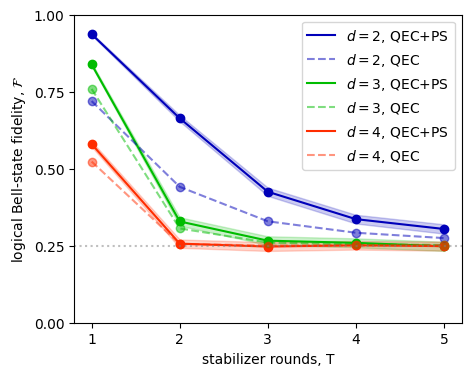

In [170]:
color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/3) for i in range(3)]
custom_lines = [line for color in color_list for line in [Line2D([0], [0], color=color),Line2D([0], [0], linestyle='--', color=color, alpha = 0.5)]]

fig = plt.figure(figsize=(5,4))

Fid_list = np.array(Fid_list_wps)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,2],'o-',c=color_list[0])
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,2],'o-',c=color_list[1])
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,2],'o-',c=color_list[2])
plt.legend(custom_lines,[label for d in range(2,5) for label in [r'$d = '+str(d)+'$, QEC+PS',r'$d = '+str(d)+'$, QEC']])
plt.fill_between(Fid_list_d2[:,1],Fid_list_d2[:,2]-Fid_list_d2[:,3],Fid_list_d2[:,2]+Fid_list_d2[:,3],color=color_list[0],alpha = 0.2)
plt.fill_between(Fid_list_d3[:,1],Fid_list_d3[:,2]-Fid_list_d3[:,3],Fid_list_d3[:,2]+Fid_list_d3[:,3],color=color_list[1],alpha = 0.2)
plt.fill_between(Fid_list_d4[:,1],Fid_list_d4[:,2]-Fid_list_d4[:,3],Fid_list_d4[:,2]+Fid_list_d4[:,3],color=color_list[2],alpha = 0.2)

Fid_list = np.array(Fid_list_nops)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,2],'o--',c=color_list[0],alpha = 0.5)
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,2],'o--',c=color_list[1],alpha = 0.5)
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,2],'o--',c=color_list[2],alpha = 0.5)

# plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5))
plt.xticks(range(1,6))
plt.xlabel(r'stabilizer rounds, T')
plt.ylabel(r'logical Bell-state fidelity, $\mathcal{F}$')
plt.axhline(0.25,color='gray',linestyle = ':',alpha = 0.5)
# plt.loglog()
# plt.savefig(home+'/figures/Fidelity_d234_vs_T_torino_data_v2.pdf',bbox_inches = 'tight')
plt.show()

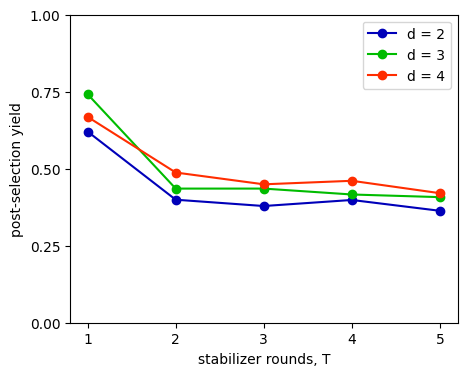

In [106]:
fig = plt.figure(figsize=(5,4))
Fid_list = np.array(Fid_list_wps)
Fid_list_d2 = Fid_list[:5]
Fid_list_d3 = Fid_list[5:10]
Fid_list_d4 = Fid_list[10:]
plt.plot(Fid_list_d2[:,1],Fid_list_d2[:,4],'o-',c=color_list[0])
plt.plot(Fid_list_d3[:,1],Fid_list_d3[:,4],'o-',c=color_list[1])
plt.plot(Fid_list_d4[:,1],Fid_list_d4[:,4],'o-',c=color_list[2])
plt.legend(['d = 2','d = 3','d = 4'])
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5))
plt.xticks(range(1,6))
plt.xlabel(r'stabilizer rounds, T')
plt.ylabel(r'post-selection yield')
# plt.loglog()
# plt.savefig(home+'/figures/Yield_d234_vs_T_torino_data_v2.pdf',bbox_inches = 'tight')
plt.show()

#### State tomography d=2, T=1

Fidelity:  (0.71956+0j)  max-CHSH:  1.922762833840929
Fidelity:  (0.936859405+0j)  max-CHSH:  2.633198316078042


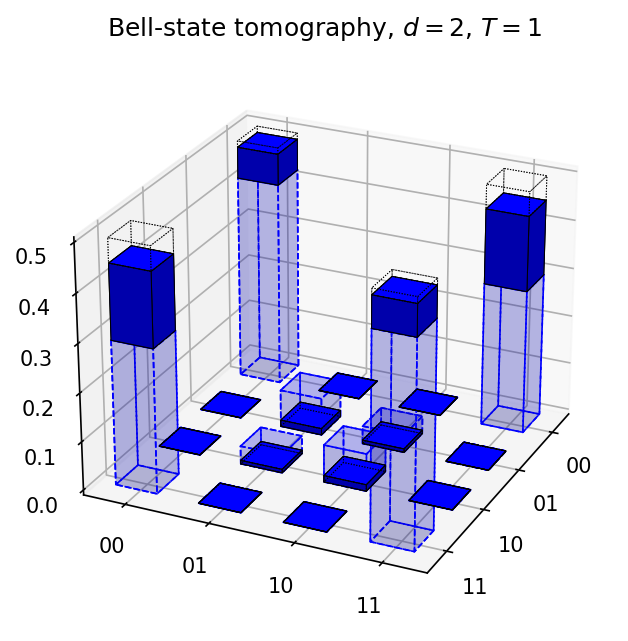

In [71]:
from matplotlib.colors import LightSource

pauliX = np.array([[0,1],[1,0]])
pauliY = np.array([[0,-1j],[1j,0]])
pauliZ = np.array([[1,0],[0,-1]])
densmat_Bell = (np.identity(4)+np.kron(pauliX,pauliX)-np.kron(pauliY,pauliY)+np.kron(pauliZ,pauliZ))/4

exp_vals = [0.16596, 1-0.24058, 0.15434]
densmat_exp_nops = (np.identity(4)+sum([(1-2*exp)*np.kron(pauli,pauli) for exp,pauli in zip(exp_vals,[pauliX,pauliY,pauliZ])]))/4
print('Fidelity: ',np.trace(densmat_Bell@densmat_exp_nops), ' max-CHSH: ',2*np.sqrt(sum(np.sort([(1-2*exp)**2 for exp in exp_vals])[1:])))

exp_vals = [0.04277058, 1-0.05711339, 0.02639722]
densmat_exp_wps = (np.identity(4)+sum([(1-2*exp)*np.kron(pauli,pauli) for exp,pauli in zip(exp_vals,[pauliX,pauliY,pauliZ])]))/4
print('Fidelity: ',np.trace(densmat_Bell@densmat_exp_wps), ' max-CHSH: ',2*np.sqrt(sum(np.sort([(1-2*exp)**2 for exp in exp_vals])[1:])))

fig=plt.figure(figsize=(5, 5), dpi=150)
ax1=plt.axes(projection='3d')

xlabels = np.array(['00', '01', '10','11'])
xpos = np.arange(xlabels.shape[0])
ylabels = np.array(['00', '01', '10','11'])
ypos = np.arange(ylabels.shape[0])

xposM, yposM = np.meshgrid(xpos, ypos, copy=False)

dx=0.5
dy=0.5
z_nops=densmat_exp_nops.real.ravel()
z_wps=densmat_exp_wps.real.ravel()

ax1.xaxis.set_ticks(xpos + dx/2.)
ax1.xaxis.set_ticklabels(xlabels)
ax1.yaxis.set_ticks(ypos + dy/2.)
ax1.yaxis.set_ticklabels(ylabels)
ax1.set_zlim(0,0.5)
ax1.set_title(r'Bell-state tomography, $d = 2$, $T = 1$')

ls = LightSource(220, 95)

ax1.bar3d(xposM.ravel(), yposM.ravel(), z_nops*0, dx, dy, z_nops, color = 'blue', edgecolor = 'blue',linestyle = '--',linewidth = .8, alpha = .15, lightsource=ls)#, color=colors)
z_start, dz  = np.array([[z*(z2>z),z2-z*(z2>z)] for z, z2 in zip(z_nops, z_wps)]).transpose()
ax1.bar3d(xposM.ravel(), yposM.ravel(), z_start, dx, dy, dz+1e-10, color = 'blue',edgecolor='black',linestyle = '-',linewidth = .5, alpha=1, lightsource=ls)
ax1.bar3d(xposM.ravel(), yposM.ravel(), z_wps, dx, dy, densmat_Bell.real.ravel()-z_wps, edgecolor='black',linestyle = ':',linewidth = .5, alpha=0., lightsource=ls)
ax1.view_init(elev=25, azim=25, roll=0)

plt.savefig(home+'/figures/densmat_torino_d2T1.pdf',bbox_inches = 'tight')
plt.show()

# Schematic figs for the HHX lattice

71


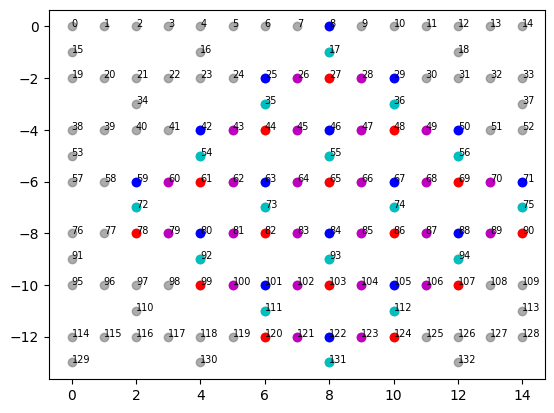

In [54]:
product_obs = True
d,T = 4,1

code = BS3CXheavyhex(d=d, T=T, log_round = [1],log_gate = ['LSXZ'],offset=-2+6j, num_qubits=133)
print(len(code.q2i3CX)+len(code.a2i3CX)+len(code.q2iBS)+len(code.a2iBS))
code.draw_lattice()

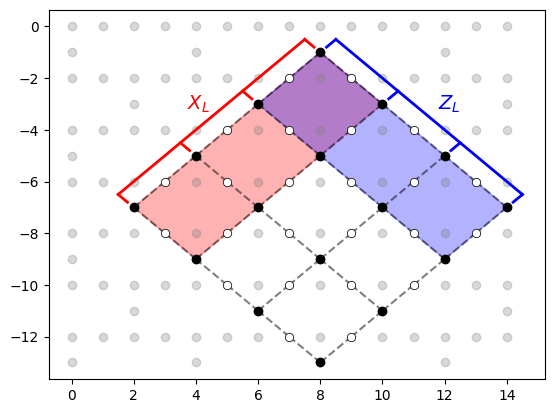

In [66]:
"settings for BS only"
plotBS,plot3CX = True,False
show_indices, show_NN_connections = False,True
show_Xstabs,show_Zstabs = True,True
show_LSXX,show_LSZZ = False,False
show_logicals = True
fname = home+'/figures/HHXlattice_BS_d4.pdf'

"settings for 3CX only"
# plotBS,plot3CX = False,True
# show_indices, show_NN_connections = False,True
# show_Xstabs,show_Zstabs = True,True
# show_LSXX,show_LSZZ = False,False
# show_logicals = True
# fname = home+'/figures/HHXlattice_3CX_d4.pdf'

"settings for LSXX"
# plotBS,plot3CX = True,True
# show_indices, show_NN_connections = False,False
# show_Xstabs,show_Zstabs = True,False
# show_LSXX,show_LSZZ = True,False
# show_logicals = True
# fname = home+'/figures/HHXlattice_LSXX_d4.pdf'

"settings for LSZZ"
# plotBS,plot3CX = True,True
# show_indices, show_NN_connections = False,False
# show_Xstabs,show_Zstabs = False,True
# show_LSXX,show_LSZZ = False,True
# show_logicals = True
# fname = home+'/figures/HHXlattice_LSZZ_d4.pdf'

qi_list, y_list, x_list = np.transpose([[item[1],item[0].imag,item[0].real] for item in code.heavyHEX_dict.items()])

yq3_list, xq3_list = np.transpose([[item[0].imag,item[0].real] for item in code.q2i3CX.items()])
ya3_list, xa3_list = np.transpose([[item[0].imag,item[0].real] for item in code.a2i3CX.items()])

yq_list, xq_list = np.transpose([[item[0].imag,item[0].real] for item in code.q2iBS.items()])
ya_list, xa_list = np.transpose([[item[0].imag,item[0].real] for item in code.a2iBS.items()])

plt.figure(frameon=False)
ax = plt.subplot(1,1,1)
plt.plot(x_list,-y_list,'o',c='gray',alpha = 0.3)
for i in [int(qi) for qi in qi_list]:
    if show_indices:
        plt.text(x_list[i],-y_list[i],str(i),fontsize=7)

if plotBS:
    if show_NN_connections:
        for label in ['BSX0','BSX1','BSZ0','BSZ1']:
            for pair in zip(*code.pair_target_pos_dict[label]):
                xs = np.real(pair)
                ys = -np.imag(pair)
                plt.plot(xs,ys,'--',c='black',alpha = 0.5)
    
    if show_Xstabs:
        if not show_Zstabs:
            ind_offset_list = list(range(code.d-1))
            ind_offset_list2 = []
        else:
            ind_offset_list = [0]
            ind_offset_list2 = list(range(1,code.d-1))
        # for ind_offset in ind_offset_list2:
        #     stab_edge_inds = [ind_offset*d,ind_offset*d+code.d-1,ind_offset*d+2*code.d-1,ind_offset*d+code.d]
        #     ax.add_patch(Polygon(np.array([xq_list[stab_edge_inds]+(ind_offset>1)*0.3,-yq_list[stab_edge_inds]+(ind_offset<2)*0.3]).T, linewidth = 5, edgecolor = 'r', fill=None,alpha = 0.4, zorder=0))
        for ind_offset in ind_offset_list:
            stab_edge_inds = [ind_offset*d,ind_offset*d+code.d-1,ind_offset*d+2*code.d-1,ind_offset*d+code.d]
            ax.add_patch(Polygon(np.array([xq_list[stab_edge_inds],-yq_list[stab_edge_inds]]).T,color = 'r',alpha = 0.3, zorder=0))
    if show_Zstabs:
        if not show_Xstabs:
            ind_offset_list = list(range(code.d-1))
            ind_offset_list2 = []
        else:
            ind_offset_list = [0]
            ind_offset_list2 = list(range(1,code.d-1))
        # for ind_offset in ind_offset_list2:
        #     stab_edge_inds = [ind_offset,ind_offset+1,ind_offset-code.d+1,ind_offset-code.d]
        #     ax.add_patch(Polygon(np.array([xq_list[stab_edge_inds]-(ind_offset>1)*0.3,-yq_list[stab_edge_inds]+(ind_offset<2)*0.3]).T, linewidth = 5, edgecolor = 'b', fill=None,alpha = 0.4, zorder=0))
        for ind_offset in ind_offset_list:
            stab_edge_inds = [ind_offset,ind_offset+1,ind_offset-code.d+1,ind_offset-code.d]
            ax.add_patch(Polygon(np.array([xq_list[stab_edge_inds],-yq_list[stab_edge_inds]]).T,color = 'b',alpha = 0.3, zorder=0))
    
    ax.plot(xq_list,-yq_list,'o',c='black')
    ax.plot(xa_list,-ya_list,'o',markeredgewidth = .5, markeredgecolor = 'black',c='white')

if plot3CX:
    if show_NN_connections:
        for label in ['3CX0','3CX1','3CX2','3CX3']:
            for pair in zip(*code.pair_target_pos_dict[label]):
                xs = np.real(pair)
                ys = -np.imag(pair)
                plt.plot(xs,ys,'--',c='black',alpha = 0.5)
    
    stab_edge_poss = [[(pos.real+rel_pos[0], -pos.imag+rel_pos[1]) 
                            for rel_pos in [(2,0),(0,2),(-2,0),(0,-2)] 
                            if (pos.real+rel_pos[0])-1.j*(-pos.imag+rel_pos[1]) in code.q2i3CX.keys()
                            ]
                        for pos in code.a2i3CX.keys() if pos not in [list(code.q2i3CX.keys())[code.d-1] + i*(2+2j)+2j for i in range(code.d)]
                        ]
    X_edge_pos = [list(code.q2i3CX.keys())[0] + i*(-2+2j) for i in range(code.d)]
    Z_edge_pos = [list(code.q2i3CX.keys())[0] + i*(2+2j) for i in range(code.d)]
    for pos1, pos2 in zip(X_edge_pos[1:-1:2],X_edge_pos[2::2]):
        stab_edge_poss.append([(pos1.real,-pos1.imag),
                                (pos1.real-0.2,-pos1.imag+0.2),
                                (pos2.real-0.2,-pos2.imag+0.2),
                                (pos2.real,-pos2.imag)
                                ])
        if code.d%2:
            stab_edge_poss.append([(pos1.real+2*code.d,-pos1.imag-2*code.d+4),
                                    (pos1.real+2*code.d+0.2,-pos1.imag-2*code.d+4-0.2),
                                    (pos2.real+2*code.d+0.2,-pos2.imag-2*code.d+4-0.2),
                                    (pos2.real+2*code.d,-pos2.imag-2*code.d+4)
                                    ][::-1])
        else:
            stab_edge_poss.append([(pos1.real+2*code.d-2,-pos1.imag-2*code.d+2),
                                    (pos1.real+2*code.d-2+0.2,-pos1.imag-2*code.d+2-0.2),
                                    (pos2.real+2*code.d-2+0.2,-pos2.imag-2*code.d+2-0.2),
                                    (pos2.real+2*code.d-2,-pos2.imag-2*code.d+2)
                                    ][::-1])
    for pos1, pos2 in zip(Z_edge_pos[:-1:2],Z_edge_pos[1::2]):
        stab_edge_poss.append([(pos1.real,-pos1.imag),
                                (pos1.real+0.2,-pos1.imag+0.2),
                                (pos2.real+0.2,-pos2.imag+0.2),
                                (pos2.real,-pos2.imag)
                                ])
        if code.d%2:
            stab_edge_poss.append([(pos1.real-2*code.d+4,-pos1.imag-2*code.d),
                                    (pos1.real-2*code.d+4-0.2,-pos1.imag-2*code.d-0.2),
                                    (pos2.real-2*code.d+4-0.2,-pos2.imag-2*code.d-0.2),
                                    (pos2.real-2*code.d+4,-pos2.imag-2*code.d)
                                    ][::-1])
        else:
            stab_edge_poss.append([(pos1.real-2*code.d+2,-pos1.imag-2*code.d+2),
                                    (pos1.real-2*code.d+2-0.2,-pos1.imag-2*code.d+2-0.2),
                                    (pos2.real-2*code.d+2-0.2,-pos2.imag-2*code.d+2-0.2),
                                    (pos2.real-2*code.d+2,-pos2.imag-2*code.d+2)
                                    ][::-1])


    for stab_edge_pos in stab_edge_poss:
        if stab_edge_pos[0][0]%4==list(code.q2i3CX.keys())[0].real%4:
            if show_Xstabs:
                ax.add_patch(Polygon(stab_edge_pos,color = 'r',alpha = 0.3, zorder=3))
        else:
            if show_Zstabs:
                ax.add_patch(Polygon(stab_edge_pos,color = 'b',alpha = 0.3, zorder=3))

    ax.plot(xq3_list,-yq3_list,'o',c='black', zorder=4)
    ax.plot(xa3_list,-ya3_list,'o',markeredgewidth = .5, markeredgecolor = 'black',c='white', zorder=4)


if show_logicals and not show_LSXX and not show_LSZZ:
    if plot3CX:
        X_edge_pos = [list(code.q2i3CX.keys())[0] + i*(-2+2j)+(-0.5-0.5j) for i in range(code.d)]
        Z_edge_pos = [list(code.q2i3CX.keys())[0] + i*(2+2j)+(+0.5-0.5j) for i in range(code.d)]
    elif plotBS:
        X_edge_pos = [list(code.q2i3CX.keys())[0] + i*(-2+2j)+1j+(-0.5-0.5j) for i in range(code.d)]
        Z_edge_pos = [list(code.q2i3CX.keys())[0] + i*(2+2j)+1j+(+0.5-0.5j) for i in range(code.d)]
    plt.plot(np.real([X_edge_pos[0],X_edge_pos[-1]]),-np.imag([X_edge_pos[0],X_edge_pos[-1]]),'r',linewidth = 2)
    for pos in X_edge_pos:
        plt.plot(np.real([pos,pos+(0.3+0.3j)]),-np.imag([pos,pos+(0.3+0.3j)]),'r',linewidth = 2)
    plt.plot(np.real([Z_edge_pos[0],Z_edge_pos[-1]]),-np.imag([Z_edge_pos[0],Z_edge_pos[-1]]),'b',linewidth = 2)
    for pos in Z_edge_pos:
        plt.plot(np.real([pos,pos+(-0.3+0.3j)]),-np.imag([pos,pos+(-0.3+0.3j)]),'b',linewidth = 2)
    X_cent = (sum(X_edge_pos)/len(X_edge_pos))
    plt.text(X_cent.real-.8,-X_cent.imag+.3,r'$X_L$',color='r',fontsize = 14)    
    Z_cent = (sum(Z_edge_pos)/len(Z_edge_pos))
    plt.text(Z_cent.real+.3,-Z_cent.imag+.3,r'$Z_L$',color='b',fontsize = 14)

if show_logicals and show_LSXX:
    X_edge_pos = [list(code.q2i3CX.keys())[0] + i*(-2+2j)+(-1.5-0.5j) for i in range(code.d)]

    plt.plot(np.real([X_edge_pos[0],X_edge_pos[-1]]),-np.imag([X_edge_pos[0],X_edge_pos[-1]]),'r',linewidth = 2)
    for pos in X_edge_pos:
        plt.plot(np.real([pos,pos+(0.3+0.3j)]),-np.imag([pos,pos+(0.3+0.3j)]),'r',linewidth = 2)
    X_cent = (sum(X_edge_pos)/len(X_edge_pos))
    plt.text(X_cent.real-1.5,-X_cent.imag+.3,r'$\langle XX \rangle$',color='r',fontsize = 14)    

if show_logicals and show_LSZZ:
    Z_edge_pos = [list(code.q2i3CX.keys())[0] + i*(2+2j)+(+1.5-0.5j) for i in range(code.d)]

    plt.plot(np.real([Z_edge_pos[0],Z_edge_pos[-1]]),-np.imag([Z_edge_pos[0],Z_edge_pos[-1]]),'b',linewidth = 2)
    for pos in Z_edge_pos:
        plt.plot(np.real([pos,pos+(-0.3+0.3j)]),-np.imag([pos,pos+(-0.3+0.3j)]),'b',linewidth = 2)
    Z_cent = (sum(Z_edge_pos)/len(Z_edge_pos))
    plt.text(Z_cent.real+.2,-Z_cent.imag+.3,r'$\langle ZZ \rangle$',color='b',fontsize = 14)

if show_LSXX:
    X3CX_edge_pos = [list(code.q2i3CX.keys())[0] + i*(-2+2j) for i in range(code.d)]
    XBS_edge_pos = [list(code.q2i3CX.keys())[0] + i*(-2+2j)+1j for i in range(code.d)]
    LSXX_anc_pos = [list(code.q2i3CX.keys())[0] + i*(-2+2j)-1 for i in range(code.d)]
    LS_edge_poss = [(pos.real,-pos.imag) for pos in  X3CX_edge_pos + XBS_edge_pos[::-1]]
    ax.add_patch(Polygon(LS_edge_poss, color = 'r', alpha = .8))
    # ax.add_patch(Polygon(LS_edge_poss, linestyle = ':', linewidth = 2, edgecolor = 'r', fill=None))

    plt.plot(np.real(LSXX_anc_pos),-np.imag(LSXX_anc_pos),'o',c='r')
    for pair in zip(X3CX_edge_pos,LSXX_anc_pos):
        xs = np.real(pair)
        ys = -np.imag(pair)
        plt.plot(xs,ys,'--',c='black',alpha = 0.5)
    for pair in zip(XBS_edge_pos,LSXX_anc_pos):
        xs = np.real(pair)
        ys = -np.imag(pair)
        plt.plot(xs,ys,'--',c='black',alpha = 0.5)

if show_LSZZ:
    Z3CX_edge_pos = [list(code.q2i3CX.keys())[0] + i*(2+2j) for i in range(code.d)]
    ZBS_edge_pos = [list(code.q2i3CX.keys())[0] + i*(2+2j)+1j for i in range(code.d)]
    LSZZ_anc_pos = [list(code.q2i3CX.keys())[0] + i*(2+2j)+1 for i in range(code.d)]
    LS_edge_poss = [(pos.real,-pos.imag) for pos in  Z3CX_edge_pos + ZBS_edge_pos[::-1]]
    ax.add_patch(Polygon(LS_edge_poss, color = 'b', alpha = .8))
    # ax.add_patch(Polygon(LS_edge_poss, linestyle = ':', linewidth = 2, edgecolor = 'b', fill=None))

    plt.plot(np.real(LSZZ_anc_pos),-np.imag(LSZZ_anc_pos),'o',c='b')
    for pair in zip(Z3CX_edge_pos,LSZZ_anc_pos):
        xs = np.real(pair)
        ys = -np.imag(pair)
        plt.plot(xs,ys,'--',c='black',alpha = 0.5)
    for pair in zip(ZBS_edge_pos,LSZZ_anc_pos):
        xs = np.real(pair)
        ys = -np.imag(pair)
        plt.plot(xs,ys,'--',c='black',alpha = 0.5)

# ax.patch.set_visible(False)
# ax.axis('off')
# plt.savefig(fname, bbox_inches='tight')

plt.show()

In [61]:
qc = QuantumCircuit(3)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(0,1)
qc.cx(1,2)

latex_string = qc.draw(output = 'latex_source')
print(r''+latex_string)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.8em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \ctrl{1} & \qw & \ctrl{1} & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \targ & \ctrl{1} & \targ & \ctrl{1} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \qw & \targ & \qw & \targ & \qw & \qw\\
\\ }}
\end{document}


In [62]:
qc = QuantumCircuit(3)
qc.cx(0,2)

latex_string = qc.draw(output = 'latex_source')
print(r''+latex_string)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.8em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \ctrl{2} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \targ & \qw & \qw\\
\\ }}
\end{document}
